In [41]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import plotly.graph_objs as go
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import json
from torch.utils.data import Dataset
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# dataset definition
class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types ={'benign':0, 'malign':1}
        self.types_count = []
        for t_type in ['benign', 'malign']:
            root_dir=Path('../data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            self.types_count.append(len(files))
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
        self.sample_weights = [1/self.types_count[label] for label in self.types]
    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                labels[self.calcifications[calcification] + 11] = 1.0
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).find("mark")
        for x in xml_data:
            if(x.tag=='svg'):
                encoded = str(x.text)
                poly_data = json.loads(x.text)
        
        labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))
        mask = np.zeros(np.shape(im))
        im = cv2.resize(im, dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
        
        # add mask 
        for polygon in poly_data:
            xs = []
            ys = []
            for point in polygon["points"]:
                xs.append(point["x"])
                ys.append(point["y"])
            contour = np.concatenate((np.expand_dims(xs, 1), np.expand_dims(ys, 1)), axis=1)
            cv2.fillPoly(mask, pts = [contour], color =(1, 1, 1))
        
        mask = cv2.resize(mask, dsize=(300, 300), interpolation=cv2.INTER_LINEAR)
        
        #im = im * mask
        
        # Adding data augmentation to avoid overfitting
        if random.randint(1, 10) > 5:
            im = np.flipud(im)
            mask = np.flipud(mask)
        if random.randint(1, 10) > 5:
            im = np.fliplr(im)
            mask = np.fliplr(mask)
        if random.randint(1, 10) > 5:
            for i in range(random.randint(1, 4)):
                im = np.rot90(im)
                mask = np.rot90(mask)
        im = np.ascontiguousarray(im)
        mask = np.ascontiguousarray(mask)
        #plt.figure()
        #plt.imshow(im)

        transforms = Compose([ToTensor()])
        mask = transforms(mask)
        im = transforms(im)
        #im = im * mask
        
        
        
        im = im.type(torch.cuda.FloatTensor)
        
        sample = {"image": im, "labels": torch.from_numpy(labels), "types" : self.types, "name": str(im_name)}
        return sample

In [43]:
# Dataset creation
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 8,
    #"shuffle": True,
}
parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_set = thyroidDataset(split='train')
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train, sampler=torch.utils.data.WeightedRandomSampler(training_set.sample_weights, len(training_set.cases), replacement=True))
totiter = len(training_generator)
a = iter(training_generator).next()

/home/ahana/thyroid/data/train/benign
/home/ahana/thyroid/data/train/malign
number of data items:73
/home/ahana/thyroid/data/train/benign
/home/ahana/thyroid/data/train/malign
number of data items:73


In [44]:
# Model definition and creation

z = 7 # groups
a = 15
k = 5 # top k 
num_labels = 1

G = np.random.randn(z, a)
W = np.random.randn(z, num_labels)

class MutualExclusivityLoss(nn.Module):
    def __init__(self, num_classes, num_attrs):
        super(MutualExclusivityLoss, self).__init__()
        self.num_attrs = num_attrs
        self.num_classes = num_classes
    def forward(self, target, result):
        target = 1.0 - target
        me_loss = target.mul(result)
        return torch.mean(me_loss)
        
   

class net(torch.nn.Module):
    
    def __init__(self, G, W):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 256,3)
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        
        self.features = [self.conv1, self.conv2, self.conv3, self.conv4]
        
        # self.fc1 = nn.Linear(14400, 120)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(256, 15)
        
        self.G_ = torch.nn.Parameter(G)
        self.W_ = torch.nn.Parameter(W)
        #self.CNN_ = torch.nn.Parameter(CNN)
        


    def forward(self, x):
            
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = self.pool(F.tanh(self.conv4(x)))
        # Adding 1 more conv, a GAP and a final linear layer for CAM
        x = F.tanh(self.conv5(x))
        features = x
        x = self.GAP(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = torch.unsqueeze(x, 2)
        
        g = torch.matmul(self.G_, x) 
        
        g = g.repeat((1, 1, num_labels))
        
        y = g * self.W_
        #y, _ = y.max(axis=2)
        
        y = torch.transpose(y, 1, 0)
        
        y = torch.sum(y, axis=0)
        return (torch.sigmoid(y), torch.sigmoid(x), features)

# Model creation and definition of losses
model = net(torch.FloatTensor(G), torch.FloatTensor(W))
model.to(device)

def projection_simplex_sort(v, z=1):

    n_features = v.size(1)
    u,_ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u,1) - z
    ind = torch.arange(n_features).type_as(v) + 1
    cond = u - cssv / ind > 0
    #rho = ind[cond][-1]
    rho,ind_rho = (ind*cond).max(1)
    #theta = cssv[cond][-1] / float(rho)
    theta = torch.gather(cssv,1,ind_rho[:,None]) / rho[:,None]
    w = torch.clamp(v - theta, min=0)
    return w

criterion = torch.nn.BCELoss(reduction='mean')

criterion1 = torch.nn.BCELoss(reduction='mean')

#criterion2 = MutualExclusivityLoss(15, 5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

#y_tr = torch.from_numpy(y_train).to(device)

In [16]:
# Load existing model
model.load_state_dict(torch.load(f'../data/models/end_to_end_v2_CAM_3.pt'))

<All keys matched successfully>

In [45]:
# perform training

epoch = 0
for epoch in range(20000):
    running_loss = 0.0
    #model.train()
    for data in training_generator:
        #model.train(True)
        x_im_train = data["image"]
        if(np.shape(x_im_train)[0]==1):
            continue
        y_im_train = data["labels"][:, 15].to(device)
        x_im_train = x_im_train.to(device)
        y_attr = data["labels"][:, :15].to(device)
        optimizer.zero_grad()

        (y_pred, attributes_pred, features) = model(x_im_train)
        
        # this needs work 
        loss = criterion(torch.squeeze(y_pred.to(float)), torch.squeeze(y_im_train.to(float))) + criterion1(torch.squeeze(attributes_pred.to(float)), torch.squeeze(y_attr.to(float))) 
        # + criterion2(torch.squeeze(attributes_pred.to(float)), torch.squeeze(y_attr.to(float)))  
    
        loss.backward()
        optimizer.step()
        model.G_.data = projection_simplex_sort(model.G_.data)
        running_loss += loss.item()
    epoch = epoch + 1
    print("Epoch: ", epoch, "; running-loss: ", running_loss)

Epoch:  1 ; running-loss:  13.699489858662258
Epoch:  2 ; running-loss:  13.687395533520906
Epoch:  3 ; running-loss:  13.660925323558839
Epoch:  4 ; running-loss:  13.631193105285039
Epoch:  5 ; running-loss:  13.634360027014136
Epoch:  6 ; running-loss:  13.626937401783577
Epoch:  7 ; running-loss:  13.689313455569836
Epoch:  8 ; running-loss:  13.62079452765006
Epoch:  9 ; running-loss:  13.560636366829046
Epoch:  10 ; running-loss:  13.538457865442943
Epoch:  11 ; running-loss:  13.51067336818128
Epoch:  12 ; running-loss:  13.341099333064271
Epoch:  13 ; running-loss:  13.215517135097485
Epoch:  14 ; running-loss:  13.307756582309755
Epoch:  15 ; running-loss:  12.99945556287297
Epoch:  16 ; running-loss:  13.132478063228286
Epoch:  17 ; running-loss:  12.934334075716555
Epoch:  18 ; running-loss:  12.924642527269757
Epoch:  19 ; running-loss:  12.649577382214352
Epoch:  20 ; running-loss:  12.443246574947162
Epoch:  21 ; running-loss:  12.41897728527002
Epoch:  22 ; running-loss:

Epoch:  175 ; running-loss:  11.598230533140832
Epoch:  176 ; running-loss:  11.709238483314723
Epoch:  177 ; running-loss:  11.790657938554357
Epoch:  178 ; running-loss:  11.599181189143778
Epoch:  179 ; running-loss:  11.378154141896157
Epoch:  180 ; running-loss:  11.645225039767936
Epoch:  181 ; running-loss:  11.634107099744133
Epoch:  182 ; running-loss:  11.53607211767827
Epoch:  183 ; running-loss:  11.301016591265434
Epoch:  184 ; running-loss:  11.425113557492223
Epoch:  185 ; running-loss:  11.36741796541114
Epoch:  186 ; running-loss:  11.887293740098531
Epoch:  187 ; running-loss:  11.52379520912301
Epoch:  188 ; running-loss:  11.741957233304412
Epoch:  189 ; running-loss:  11.75342241731359
Epoch:  190 ; running-loss:  11.442138583738288
Epoch:  191 ; running-loss:  11.48100964815231
Epoch:  192 ; running-loss:  11.782094563859536
Epoch:  193 ; running-loss:  11.419157210757948
Epoch:  194 ; running-loss:  11.628003995510628
Epoch:  195 ; running-loss:  11.7141510819210

Epoch:  347 ; running-loss:  11.511268901405115
Epoch:  348 ; running-loss:  11.650015000044583
Epoch:  349 ; running-loss:  11.573404423755395
Epoch:  350 ; running-loss:  11.197430219234832
Epoch:  351 ; running-loss:  11.465266613774302
Epoch:  352 ; running-loss:  11.886470258652697
Epoch:  353 ; running-loss:  11.568641683196828
Epoch:  354 ; running-loss:  11.798629464944158
Epoch:  355 ; running-loss:  11.987247651215359
Epoch:  356 ; running-loss:  11.274217715101383
Epoch:  357 ; running-loss:  11.175951219168502
Epoch:  358 ; running-loss:  11.853134845202892
Epoch:  359 ; running-loss:  11.297931376486718
Epoch:  360 ; running-loss:  11.808253933461867
Epoch:  361 ; running-loss:  11.583118513354062
Epoch:  362 ; running-loss:  11.376363127630906
Epoch:  363 ; running-loss:  11.76205872294618
Epoch:  364 ; running-loss:  11.867818207596303
Epoch:  365 ; running-loss:  11.54761867235463
Epoch:  366 ; running-loss:  11.643263010606207
Epoch:  367 ; running-loss:  11.4021262585

Epoch:  519 ; running-loss:  11.480251576240232
Epoch:  520 ; running-loss:  11.226258247619674
Epoch:  521 ; running-loss:  11.10549998196218
Epoch:  522 ; running-loss:  11.414336294429416
Epoch:  523 ; running-loss:  11.409603398276948
Epoch:  524 ; running-loss:  11.339261587016903
Epoch:  525 ; running-loss:  11.625082389949716
Epoch:  526 ; running-loss:  11.317634210250956
Epoch:  527 ; running-loss:  11.320282551198508
Epoch:  528 ; running-loss:  11.511074176850213
Epoch:  529 ; running-loss:  11.622257565454364
Epoch:  530 ; running-loss:  11.039833264402168
Epoch:  531 ; running-loss:  11.366287561946756
Epoch:  532 ; running-loss:  11.337780269532153
Epoch:  533 ; running-loss:  11.354491556946071
Epoch:  534 ; running-loss:  11.45147690416873
Epoch:  535 ; running-loss:  11.547370945361818
Epoch:  536 ; running-loss:  11.530510818174076
Epoch:  537 ; running-loss:  11.154261519430921
Epoch:  538 ; running-loss:  11.553834974978226
Epoch:  539 ; running-loss:  11.6371353228

Epoch:  691 ; running-loss:  11.496138445544705
Epoch:  692 ; running-loss:  11.186346444641472
Epoch:  693 ; running-loss:  11.722607806172885
Epoch:  694 ; running-loss:  11.269790003488367
Epoch:  695 ; running-loss:  11.377433439423642
Epoch:  696 ; running-loss:  11.41251730523307
Epoch:  697 ; running-loss:  11.107379121655079
Epoch:  698 ; running-loss:  11.376432981732234
Epoch:  699 ; running-loss:  11.382715370578893
Epoch:  700 ; running-loss:  11.689370075677711
Epoch:  701 ; running-loss:  11.504448957859138
Epoch:  702 ; running-loss:  11.418200236046324
Epoch:  703 ; running-loss:  11.692180870560868
Epoch:  704 ; running-loss:  11.312256455688718
Epoch:  705 ; running-loss:  11.748522630509996
Epoch:  706 ; running-loss:  11.536010512017716
Epoch:  707 ; running-loss:  11.01421212259002
Epoch:  708 ; running-loss:  11.431616267375
Epoch:  709 ; running-loss:  11.682836090546846
Epoch:  710 ; running-loss:  11.585080681426097
Epoch:  711 ; running-loss:  11.6277993484175

Epoch:  863 ; running-loss:  11.677173034121106
Epoch:  864 ; running-loss:  11.140807438278186
Epoch:  865 ; running-loss:  11.27293327295026
Epoch:  866 ; running-loss:  11.018062830689118
Epoch:  867 ; running-loss:  11.849004842928672
Epoch:  868 ; running-loss:  11.114349541501038
Epoch:  869 ; running-loss:  10.970533521366793
Epoch:  870 ; running-loss:  11.125392261927969
Epoch:  871 ; running-loss:  11.401894731171351
Epoch:  872 ; running-loss:  11.202906310842874
Epoch:  873 ; running-loss:  11.586128231406947
Epoch:  874 ; running-loss:  10.941580828240031
Epoch:  875 ; running-loss:  11.49088275079352
Epoch:  876 ; running-loss:  11.039035379341298
Epoch:  877 ; running-loss:  10.931592863186372
Epoch:  878 ; running-loss:  11.0406067933698
Epoch:  879 ; running-loss:  11.669460052517042
Epoch:  880 ; running-loss:  11.27379495051765
Epoch:  881 ; running-loss:  11.332475292921286
Epoch:  882 ; running-loss:  11.554041013231041
Epoch:  883 ; running-loss:  10.8400924354508

Epoch:  1034 ; running-loss:  11.30372617318725
Epoch:  1035 ; running-loss:  11.443722893739556
Epoch:  1036 ; running-loss:  11.556451672257078
Epoch:  1037 ; running-loss:  11.404678902785143
Epoch:  1038 ; running-loss:  11.226667110887952
Epoch:  1039 ; running-loss:  11.720189678559844
Epoch:  1040 ; running-loss:  11.332718284834495
Epoch:  1041 ; running-loss:  11.119499353121414
Epoch:  1042 ; running-loss:  11.475098595438098
Epoch:  1043 ; running-loss:  11.263749279972636
Epoch:  1044 ; running-loss:  11.175580802532714
Epoch:  1045 ; running-loss:  11.41305673297358
Epoch:  1046 ; running-loss:  11.176453801150643
Epoch:  1047 ; running-loss:  11.401886479405558
Epoch:  1048 ; running-loss:  10.791148267070561
Epoch:  1049 ; running-loss:  10.76189533483083
Epoch:  1050 ; running-loss:  11.327448104278108
Epoch:  1051 ; running-loss:  11.759185719953333
Epoch:  1052 ; running-loss:  11.262327927812324
Epoch:  1053 ; running-loss:  11.630432297714513
Epoch:  1054 ; running-

Epoch:  1202 ; running-loss:  10.97145727381583
Epoch:  1203 ; running-loss:  11.202667641192933
Epoch:  1204 ; running-loss:  11.592134847292803
Epoch:  1205 ; running-loss:  11.210334397425285
Epoch:  1206 ; running-loss:  11.652897673200073
Epoch:  1207 ; running-loss:  11.635375572671439
Epoch:  1208 ; running-loss:  11.129013761355065
Epoch:  1209 ; running-loss:  11.098695285792926
Epoch:  1210 ; running-loss:  11.368955100164031
Epoch:  1211 ; running-loss:  11.038430715626646
Epoch:  1212 ; running-loss:  11.420030520474205
Epoch:  1213 ; running-loss:  11.127280771821216
Epoch:  1214 ; running-loss:  11.331198067786344
Epoch:  1215 ; running-loss:  11.403380677242934
Epoch:  1216 ; running-loss:  11.661291998228865
Epoch:  1217 ; running-loss:  11.260888929607171
Epoch:  1218 ; running-loss:  10.9690769177378
Epoch:  1219 ; running-loss:  11.334280983915498
Epoch:  1220 ; running-loss:  11.387301822223211
Epoch:  1221 ; running-loss:  11.176126086954183
Epoch:  1222 ; running-

Epoch:  1370 ; running-loss:  11.494560638752302
Epoch:  1371 ; running-loss:  11.372695217742995
Epoch:  1372 ; running-loss:  10.69167067077199
Epoch:  1373 ; running-loss:  11.36000228330244
Epoch:  1374 ; running-loss:  10.996962667215175
Epoch:  1375 ; running-loss:  11.506300051660714
Epoch:  1376 ; running-loss:  11.650588676354504
Epoch:  1377 ; running-loss:  11.371041187997823
Epoch:  1378 ; running-loss:  11.4304425145584
Epoch:  1379 ; running-loss:  10.520693101605065
Epoch:  1380 ; running-loss:  11.490115471175713
Epoch:  1381 ; running-loss:  11.117061717006802
Epoch:  1382 ; running-loss:  10.793819315723175
Epoch:  1383 ; running-loss:  10.426287504689155
Epoch:  1384 ; running-loss:  11.448948347678137
Epoch:  1385 ; running-loss:  11.051864511370264
Epoch:  1386 ; running-loss:  11.270283332207343
Epoch:  1387 ; running-loss:  11.074818319603901
Epoch:  1388 ; running-loss:  11.514232827558404
Epoch:  1389 ; running-loss:  11.133753949257622
Epoch:  1390 ; running-l

Epoch:  1538 ; running-loss:  10.783432052489818
Epoch:  1539 ; running-loss:  11.364039123003353
Epoch:  1540 ; running-loss:  11.000952268400315
Epoch:  1541 ; running-loss:  10.92588020531012
Epoch:  1542 ; running-loss:  10.80285214859575
Epoch:  1543 ; running-loss:  10.705744986338631
Epoch:  1544 ; running-loss:  10.82453976470877
Epoch:  1545 ; running-loss:  11.270632318396583
Epoch:  1546 ; running-loss:  11.145249275843177
Epoch:  1547 ; running-loss:  10.81254152977531
Epoch:  1548 ; running-loss:  10.915154861275415
Epoch:  1549 ; running-loss:  11.795024328224228
Epoch:  1550 ; running-loss:  10.888678766956996
Epoch:  1551 ; running-loss:  10.925462393872287
Epoch:  1552 ; running-loss:  11.383640654455881
Epoch:  1553 ; running-loss:  11.019266574364366
Epoch:  1554 ; running-loss:  11.162395141913967
Epoch:  1555 ; running-loss:  11.283756253629521
Epoch:  1556 ; running-loss:  11.275773273552558
Epoch:  1557 ; running-loss:  11.415215496907987
Epoch:  1558 ; running-l

Epoch:  1706 ; running-loss:  11.156649354046083
Epoch:  1707 ; running-loss:  11.255780955516125
Epoch:  1708 ; running-loss:  10.662904526802713
Epoch:  1709 ; running-loss:  11.001386051861449
Epoch:  1710 ; running-loss:  10.84789637907052
Epoch:  1711 ; running-loss:  11.371425280661674
Epoch:  1712 ; running-loss:  10.69066028493754
Epoch:  1713 ; running-loss:  10.79251075311557
Epoch:  1714 ; running-loss:  11.01468735879077
Epoch:  1715 ; running-loss:  10.99799954442226
Epoch:  1716 ; running-loss:  11.528711323096966
Epoch:  1717 ; running-loss:  11.165198262068428
Epoch:  1718 ; running-loss:  10.60142910099066
Epoch:  1719 ; running-loss:  11.221459627796028
Epoch:  1720 ; running-loss:  10.788061865406558
Epoch:  1721 ; running-loss:  11.294509857238436
Epoch:  1722 ; running-loss:  10.742595514915099
Epoch:  1723 ; running-loss:  11.240148502236401
Epoch:  1724 ; running-loss:  11.031385765155285
Epoch:  1725 ; running-loss:  10.997454904497202
Epoch:  1726 ; running-los

Epoch:  1874 ; running-loss:  10.768158646740991
Epoch:  1875 ; running-loss:  10.792691582319405
Epoch:  1876 ; running-loss:  11.054503927585497
Epoch:  1877 ; running-loss:  10.732700652381356
Epoch:  1878 ; running-loss:  10.941149617243779
Epoch:  1879 ; running-loss:  11.30250709684533
Epoch:  1880 ; running-loss:  11.006933684672994
Epoch:  1881 ; running-loss:  11.039665636070408
Epoch:  1882 ; running-loss:  10.735467710064702
Epoch:  1883 ; running-loss:  10.483059479758964
Epoch:  1884 ; running-loss:  10.612105276827217
Epoch:  1885 ; running-loss:  10.748134316918033
Epoch:  1886 ; running-loss:  11.157864938570333
Epoch:  1887 ; running-loss:  11.121143045948697
Epoch:  1888 ; running-loss:  10.590393113656761
Epoch:  1889 ; running-loss:  10.718842511150235
Epoch:  1890 ; running-loss:  10.499695330875012
Epoch:  1891 ; running-loss:  11.385938398442812
Epoch:  1892 ; running-loss:  11.296722397137588
Epoch:  1893 ; running-loss:  10.792176418519363
Epoch:  1894 ; runnin

Epoch:  2042 ; running-loss:  11.265867554578815
Epoch:  2043 ; running-loss:  11.487529122076069
Epoch:  2044 ; running-loss:  10.975503719727877
Epoch:  2045 ; running-loss:  10.948843827198681
Epoch:  2046 ; running-loss:  10.432323400367085
Epoch:  2047 ; running-loss:  11.212983042256315
Epoch:  2048 ; running-loss:  10.873751815006282
Epoch:  2049 ; running-loss:  10.788824111749934
Epoch:  2050 ; running-loss:  10.709543959626187
Epoch:  2051 ; running-loss:  11.402025429430605
Epoch:  2052 ; running-loss:  11.127777961275068
Epoch:  2053 ; running-loss:  11.14458655157417
Epoch:  2054 ; running-loss:  10.987919130790285
Epoch:  2055 ; running-loss:  11.475981201542426
Epoch:  2056 ; running-loss:  10.70986668924084
Epoch:  2057 ; running-loss:  11.197573854346459
Epoch:  2058 ; running-loss:  10.450604418065282
Epoch:  2059 ; running-loss:  11.09525409510506
Epoch:  2060 ; running-loss:  10.73321565922511
Epoch:  2061 ; running-loss:  11.15394183451322
Epoch:  2062 ; running-lo

Epoch:  2211 ; running-loss:  11.093870637882262
Epoch:  2212 ; running-loss:  11.08058979555526
Epoch:  2213 ; running-loss:  10.972381802546396
Epoch:  2214 ; running-loss:  10.237286054631507
Epoch:  2215 ; running-loss:  10.804973254694609
Epoch:  2216 ; running-loss:  11.610051567801165
Epoch:  2217 ; running-loss:  10.818081276749442
Epoch:  2218 ; running-loss:  11.156006289795547
Epoch:  2219 ; running-loss:  11.159175984747343
Epoch:  2220 ; running-loss:  10.98562626835588
Epoch:  2221 ; running-loss:  10.849024436699628
Epoch:  2222 ; running-loss:  11.20647362857651
Epoch:  2223 ; running-loss:  10.85438363626392
Epoch:  2224 ; running-loss:  10.579677788486055
Epoch:  2225 ; running-loss:  10.819209233674304
Epoch:  2226 ; running-loss:  10.934835648858945
Epoch:  2227 ; running-loss:  11.134052349036239
Epoch:  2228 ; running-loss:  11.243006597110995
Epoch:  2229 ; running-loss:  11.020378363538597
Epoch:  2230 ; running-loss:  10.713970024889333
Epoch:  2231 ; running-l

Epoch:  2379 ; running-loss:  10.772251419610907
Epoch:  2380 ; running-loss:  10.858784536140506
Epoch:  2381 ; running-loss:  10.645135472560401
Epoch:  2382 ; running-loss:  11.142246103458337
Epoch:  2383 ; running-loss:  10.673641752008301
Epoch:  2384 ; running-loss:  10.819362871036747
Epoch:  2385 ; running-loss:  10.552510371381125
Epoch:  2386 ; running-loss:  11.52918646635083
Epoch:  2387 ; running-loss:  10.824884249325375
Epoch:  2388 ; running-loss:  10.887456826586625
Epoch:  2389 ; running-loss:  10.950067385142457
Epoch:  2390 ; running-loss:  10.36680502159251
Epoch:  2391 ; running-loss:  10.86525392383644
Epoch:  2392 ; running-loss:  11.180562058401133
Epoch:  2393 ; running-loss:  11.056305736755387
Epoch:  2394 ; running-loss:  11.14348659915834
Epoch:  2395 ; running-loss:  11.500334235889632
Epoch:  2396 ; running-loss:  10.748626002845365
Epoch:  2397 ; running-loss:  10.636167381588011
Epoch:  2398 ; running-loss:  11.000411183792007
Epoch:  2399 ; running-l

Epoch:  2547 ; running-loss:  11.203782994124463
Epoch:  2548 ; running-loss:  10.698619315639363
Epoch:  2549 ; running-loss:  11.124704577965817
Epoch:  2550 ; running-loss:  10.532942373900937
Epoch:  2551 ; running-loss:  10.432649498674975
Epoch:  2552 ; running-loss:  10.823817425619662
Epoch:  2553 ; running-loss:  10.950363132605574
Epoch:  2554 ; running-loss:  10.765776727618288
Epoch:  2555 ; running-loss:  10.85243153125268
Epoch:  2556 ; running-loss:  10.641570425157377
Epoch:  2557 ; running-loss:  10.992730186120266
Epoch:  2558 ; running-loss:  10.856101669072293
Epoch:  2559 ; running-loss:  10.937145170035096
Epoch:  2560 ; running-loss:  11.150597369825908
Epoch:  2561 ; running-loss:  10.521662543176106
Epoch:  2562 ; running-loss:  10.78469237762853
Epoch:  2563 ; running-loss:  10.80295016727816
Epoch:  2564 ; running-loss:  10.37534933096103
Epoch:  2565 ; running-loss:  10.643763164027046
Epoch:  2566 ; running-loss:  10.815837355569663
Epoch:  2567 ; running-l

Epoch:  2715 ; running-loss:  10.881789774412507
Epoch:  2716 ; running-loss:  10.701896087453544
Epoch:  2717 ; running-loss:  11.140567531972437
Epoch:  2718 ; running-loss:  11.451291083749377
Epoch:  2719 ; running-loss:  10.58890630262797
Epoch:  2720 ; running-loss:  11.214374068375319
Epoch:  2721 ; running-loss:  10.998458729065385
Epoch:  2722 ; running-loss:  10.596811440568795
Epoch:  2723 ; running-loss:  10.934674216994658
Epoch:  2724 ; running-loss:  11.146136565595935
Epoch:  2725 ; running-loss:  10.939725005469537
Epoch:  2726 ; running-loss:  10.680615835905469
Epoch:  2727 ; running-loss:  10.979694096994644
Epoch:  2728 ; running-loss:  10.433440901346605
Epoch:  2729 ; running-loss:  10.522769677021174
Epoch:  2730 ; running-loss:  11.293889051694828
Epoch:  2731 ; running-loss:  11.058023298312339
Epoch:  2732 ; running-loss:  10.707393323171562
Epoch:  2733 ; running-loss:  10.56368244201164
Epoch:  2734 ; running-loss:  10.818530110106288
Epoch:  2735 ; running

Epoch:  2883 ; running-loss:  11.391584511674983
Epoch:  2884 ; running-loss:  10.64263979196741
Epoch:  2885 ; running-loss:  9.978977941282224
Epoch:  2886 ; running-loss:  11.055724019564408
Epoch:  2887 ; running-loss:  10.817019184558404
Epoch:  2888 ; running-loss:  10.58099555189149
Epoch:  2889 ; running-loss:  10.526077807767054
Epoch:  2890 ; running-loss:  10.334559902402168
Epoch:  2891 ; running-loss:  11.268233026910867
Epoch:  2892 ; running-loss:  10.999223799571396
Epoch:  2893 ; running-loss:  10.612611040055418
Epoch:  2894 ; running-loss:  10.596618028228633
Epoch:  2895 ; running-loss:  10.869049388616457
Epoch:  2896 ; running-loss:  9.902882203547373
Epoch:  2897 ; running-loss:  10.943266576409762
Epoch:  2898 ; running-loss:  10.772914157311055
Epoch:  2899 ; running-loss:  10.703281896338908
Epoch:  2900 ; running-loss:  10.433715341694093
Epoch:  2901 ; running-loss:  11.029452098626285
Epoch:  2902 ; running-loss:  10.730005402880813
Epoch:  2903 ; running-l

Epoch:  3052 ; running-loss:  10.778165909988443
Epoch:  3053 ; running-loss:  10.858675741625897
Epoch:  3054 ; running-loss:  10.542618545086919
Epoch:  3055 ; running-loss:  10.508019366069579
Epoch:  3056 ; running-loss:  10.32377793028402
Epoch:  3057 ; running-loss:  10.787618849685513
Epoch:  3058 ; running-loss:  10.917579031582445
Epoch:  3059 ; running-loss:  10.628520939743925
Epoch:  3060 ; running-loss:  10.764840525265674
Epoch:  3061 ; running-loss:  10.595904962921448
Epoch:  3062 ; running-loss:  10.753850422780681
Epoch:  3063 ; running-loss:  10.482899543237146
Epoch:  3064 ; running-loss:  10.404221389584313
Epoch:  3065 ; running-loss:  10.721754208800974
Epoch:  3066 ; running-loss:  10.712538768600947
Epoch:  3067 ; running-loss:  11.216004194518607
Epoch:  3068 ; running-loss:  10.575057285330043
Epoch:  3069 ; running-loss:  10.47112304653866
Epoch:  3070 ; running-loss:  11.307195099629999
Epoch:  3071 ; running-loss:  10.136585334149093
Epoch:  3072 ; running

Epoch:  3220 ; running-loss:  10.478980309636643
Epoch:  3221 ; running-loss:  10.760912290060508
Epoch:  3222 ; running-loss:  10.228053307415763
Epoch:  3223 ; running-loss:  10.73789450381669
Epoch:  3224 ; running-loss:  10.348218329544022
Epoch:  3225 ; running-loss:  10.70708436153379
Epoch:  3226 ; running-loss:  10.78585948114775
Epoch:  3227 ; running-loss:  10.606238445322822
Epoch:  3228 ; running-loss:  10.79569816355018
Epoch:  3229 ; running-loss:  10.941782407268779
Epoch:  3230 ; running-loss:  11.280147987605746
Epoch:  3231 ; running-loss:  11.161552907945719
Epoch:  3232 ; running-loss:  10.308980048869042
Epoch:  3233 ; running-loss:  10.51314296608877
Epoch:  3234 ; running-loss:  10.601836959275303
Epoch:  3235 ; running-loss:  10.913950687157627
Epoch:  3236 ; running-loss:  10.880623789352684
Epoch:  3237 ; running-loss:  10.268204574336442
Epoch:  3238 ; running-loss:  10.158865261544133
Epoch:  3239 ; running-loss:  10.145877071468057
Epoch:  3240 ; running-lo

Epoch:  3389 ; running-loss:  10.877194471842397
Epoch:  3390 ; running-loss:  10.073657012175293
Epoch:  3391 ; running-loss:  10.823015841976478
Epoch:  3392 ; running-loss:  9.906584749862793
Epoch:  3393 ; running-loss:  10.755369840390701
Epoch:  3394 ; running-loss:  10.531208942570922
Epoch:  3395 ; running-loss:  10.136365182798775
Epoch:  3396 ; running-loss:  10.144748493131939
Epoch:  3397 ; running-loss:  10.382031001583071
Epoch:  3398 ; running-loss:  11.076536789991124
Epoch:  3399 ; running-loss:  10.717998142574487
Epoch:  3400 ; running-loss:  10.451100020050344
Epoch:  3401 ; running-loss:  10.027959066725403
Epoch:  3402 ; running-loss:  10.113342964503474
Epoch:  3403 ; running-loss:  10.809183808856849
Epoch:  3404 ; running-loss:  9.553786394419095
Epoch:  3405 ; running-loss:  10.171815036591415
Epoch:  3406 ; running-loss:  10.466147155111573
Epoch:  3407 ; running-loss:  9.827879448691474
Epoch:  3408 ; running-loss:  10.395611673974487
Epoch:  3409 ; running-

Epoch:  3558 ; running-loss:  10.220467644845904
Epoch:  3559 ; running-loss:  10.558035016836147
Epoch:  3560 ; running-loss:  10.878395255479756
Epoch:  3561 ; running-loss:  10.771139463334896
Epoch:  3562 ; running-loss:  10.427282399460331
Epoch:  3563 ; running-loss:  9.923894295877353
Epoch:  3564 ; running-loss:  10.352709151954942
Epoch:  3565 ; running-loss:  10.82811070626086
Epoch:  3566 ; running-loss:  10.768707260529645
Epoch:  3567 ; running-loss:  10.870038449526602
Epoch:  3568 ; running-loss:  10.458567280743683
Epoch:  3569 ; running-loss:  10.82325075916623
Epoch:  3570 ; running-loss:  11.211381528607527
Epoch:  3571 ; running-loss:  10.814716104206235
Epoch:  3572 ; running-loss:  10.42391517831745
Epoch:  3573 ; running-loss:  10.566673173824805
Epoch:  3574 ; running-loss:  10.199445090056301
Epoch:  3575 ; running-loss:  10.702738417301475
Epoch:  3576 ; running-loss:  10.60928559045674
Epoch:  3577 ; running-loss:  10.877412287958764
Epoch:  3578 ; running-lo

Epoch:  3727 ; running-loss:  10.670190866921743
Epoch:  3728 ; running-loss:  10.626798729130549
Epoch:  3729 ; running-loss:  10.37796158580819
Epoch:  3730 ; running-loss:  10.255595454765917
Epoch:  3731 ; running-loss:  10.338087726835292
Epoch:  3732 ; running-loss:  10.50738068902919
Epoch:  3733 ; running-loss:  10.44194496619871
Epoch:  3734 ; running-loss:  10.471743647970671
Epoch:  3735 ; running-loss:  10.769474926477063
Epoch:  3736 ; running-loss:  10.398003696260643
Epoch:  3737 ; running-loss:  10.322671103739502
Epoch:  3738 ; running-loss:  10.388974988436626
Epoch:  3739 ; running-loss:  10.167897343629763
Epoch:  3740 ; running-loss:  10.516116220709943
Epoch:  3741 ; running-loss:  10.246003659681913
Epoch:  3742 ; running-loss:  10.790616910089431
Epoch:  3743 ; running-loss:  10.243252253856655
Epoch:  3744 ; running-loss:  10.670392665530173
Epoch:  3745 ; running-loss:  10.956703776357989
Epoch:  3746 ; running-loss:  10.41117240927749
Epoch:  3747 ; running-l

Epoch:  3896 ; running-loss:  10.532180136468744
Epoch:  3897 ; running-loss:  10.656512888270354
Epoch:  3898 ; running-loss:  9.897559829508253
Epoch:  3899 ; running-loss:  10.246321005298404
Epoch:  3900 ; running-loss:  9.880679348362307
Epoch:  3901 ; running-loss:  10.825446608404176
Epoch:  3902 ; running-loss:  10.898721910167287
Epoch:  3903 ; running-loss:  10.488442715221755
Epoch:  3904 ; running-loss:  11.03687368374679
Epoch:  3905 ; running-loss:  10.226204811672709
Epoch:  3906 ; running-loss:  10.734401080300632
Epoch:  3907 ; running-loss:  10.611144262939124
Epoch:  3908 ; running-loss:  10.528037624779248
Epoch:  3909 ; running-loss:  9.463283915700137
Epoch:  3910 ; running-loss:  10.58391559488274
Epoch:  3911 ; running-loss:  10.287840619056311
Epoch:  3912 ; running-loss:  10.41919112967787
Epoch:  3913 ; running-loss:  9.955868628190757
Epoch:  3914 ; running-loss:  10.318586570660326
Epoch:  3915 ; running-loss:  10.701223975119138
Epoch:  3916 ; running-loss

Epoch:  4065 ; running-loss:  10.860676681683843
Epoch:  4066 ; running-loss:  10.053363397053538
Epoch:  4067 ; running-loss:  10.038359519084159
Epoch:  4068 ; running-loss:  9.754816040003066
Epoch:  4069 ; running-loss:  10.267933749831828
Epoch:  4070 ; running-loss:  9.76586459575639
Epoch:  4071 ; running-loss:  9.65741998409873
Epoch:  4072 ; running-loss:  10.237122364393429
Epoch:  4073 ; running-loss:  9.988247607683178
Epoch:  4074 ; running-loss:  9.818819306584427
Epoch:  4075 ; running-loss:  10.408318920228929
Epoch:  4076 ; running-loss:  10.051111606206897
Epoch:  4077 ; running-loss:  10.301974005594658
Epoch:  4078 ; running-loss:  10.413455774081669
Epoch:  4079 ; running-loss:  10.655697482923932
Epoch:  4080 ; running-loss:  10.30743643685035
Epoch:  4081 ; running-loss:  9.754258085338797
Epoch:  4082 ; running-loss:  10.3545176634706
Epoch:  4083 ; running-loss:  10.31805154597286
Epoch:  4084 ; running-loss:  10.434271584248954
Epoch:  4085 ; running-loss:  10

Epoch:  4234 ; running-loss:  10.353134573690895
Epoch:  4235 ; running-loss:  9.433289764502412
Epoch:  4236 ; running-loss:  10.018606165745648
Epoch:  4237 ; running-loss:  10.10263655620463
Epoch:  4238 ; running-loss:  9.936494125817058
Epoch:  4239 ; running-loss:  10.059232102472542
Epoch:  4240 ; running-loss:  10.091660374046466
Epoch:  4241 ; running-loss:  10.327030936781622
Epoch:  4242 ; running-loss:  9.961621645040141
Epoch:  4243 ; running-loss:  10.880643408525367
Epoch:  4244 ; running-loss:  10.586192267203774
Epoch:  4245 ; running-loss:  10.552178342091398
Epoch:  4246 ; running-loss:  10.012759827756533
Epoch:  4247 ; running-loss:  10.46636163294592
Epoch:  4248 ; running-loss:  9.851596835051907
Epoch:  4249 ; running-loss:  9.989070029895547
Epoch:  4250 ; running-loss:  10.449247563526633
Epoch:  4251 ; running-loss:  10.163434696887485
Epoch:  4252 ; running-loss:  9.4403913450667
Epoch:  4253 ; running-loss:  9.74880121832923
Epoch:  4254 ; running-loss:  10

Epoch:  4403 ; running-loss:  10.368737578390794
Epoch:  4404 ; running-loss:  10.495754353518594
Epoch:  4405 ; running-loss:  10.394830223012697
Epoch:  4406 ; running-loss:  10.00411592833349
Epoch:  4407 ; running-loss:  10.422788735534068
Epoch:  4408 ; running-loss:  10.669163993739184
Epoch:  4409 ; running-loss:  9.820996049765904
Epoch:  4410 ; running-loss:  9.972914527317691
Epoch:  4411 ; running-loss:  10.066023230310554
Epoch:  4412 ; running-loss:  9.913801547641599
Epoch:  4413 ; running-loss:  10.477082044506457
Epoch:  4414 ; running-loss:  9.657167664245408
Epoch:  4415 ; running-loss:  9.511598273224873
Epoch:  4416 ; running-loss:  10.385934628031826
Epoch:  4417 ; running-loss:  10.458412992206618
Epoch:  4418 ; running-loss:  10.03673295216559
Epoch:  4419 ; running-loss:  9.856580364914828
Epoch:  4420 ; running-loss:  9.834877674319083
Epoch:  4421 ; running-loss:  9.840870883722205
Epoch:  4422 ; running-loss:  9.280721788302126
Epoch:  4423 ; running-loss:  1

Epoch:  4573 ; running-loss:  9.728312697768231
Epoch:  4574 ; running-loss:  10.305264788173957
Epoch:  4575 ; running-loss:  10.265275093121495
Epoch:  4576 ; running-loss:  9.841692193124516
Epoch:  4577 ; running-loss:  9.76632855318585
Epoch:  4578 ; running-loss:  10.165847674272047
Epoch:  4579 ; running-loss:  10.602083735137935
Epoch:  4580 ; running-loss:  10.096860656249854
Epoch:  4581 ; running-loss:  9.85031069878962
Epoch:  4582 ; running-loss:  9.822242321534565
Epoch:  4583 ; running-loss:  9.855936700068249
Epoch:  4584 ; running-loss:  10.192587916036668
Epoch:  4585 ; running-loss:  9.691891196139762
Epoch:  4586 ; running-loss:  9.984283840473863
Epoch:  4587 ; running-loss:  9.994125669316361
Epoch:  4588 ; running-loss:  9.686098666239802
Epoch:  4589 ; running-loss:  10.688499565089488
Epoch:  4590 ; running-loss:  10.263259464093304
Epoch:  4591 ; running-loss:  10.117161933440181
Epoch:  4592 ; running-loss:  10.193102675715568
Epoch:  4593 ; running-loss:  10

Epoch:  4743 ; running-loss:  9.2646657768754
Epoch:  4744 ; running-loss:  10.059958533673846
Epoch:  4745 ; running-loss:  9.17967914838564
Epoch:  4746 ; running-loss:  9.874905448098003
Epoch:  4747 ; running-loss:  10.552967050620373
Epoch:  4748 ; running-loss:  10.533192030144818
Epoch:  4749 ; running-loss:  10.035304481954114
Epoch:  4750 ; running-loss:  10.042734707585115
Epoch:  4751 ; running-loss:  10.409774634207436
Epoch:  4752 ; running-loss:  10.21282164220165
Epoch:  4753 ; running-loss:  10.083362227736174
Epoch:  4754 ; running-loss:  10.647225651641724
Epoch:  4755 ; running-loss:  9.699557887529066
Epoch:  4756 ; running-loss:  9.822331665858407
Epoch:  4757 ; running-loss:  10.756011388098491
Epoch:  4758 ; running-loss:  10.351961815981852
Epoch:  4759 ; running-loss:  9.989967408430115
Epoch:  4760 ; running-loss:  10.306852425571083
Epoch:  4761 ; running-loss:  10.38451498478868
Epoch:  4762 ; running-loss:  10.160345200374866
Epoch:  4763 ; running-loss:  1

Epoch:  4913 ; running-loss:  9.962810511026522
Epoch:  4914 ; running-loss:  10.215995417012625
Epoch:  4915 ; running-loss:  9.718933903646292
Epoch:  4916 ; running-loss:  9.09501559502076
Epoch:  4917 ; running-loss:  9.529638192334932
Epoch:  4918 ; running-loss:  9.97859452051736
Epoch:  4919 ; running-loss:  10.072427776322948
Epoch:  4920 ; running-loss:  9.938411019325587
Epoch:  4921 ; running-loss:  10.108253625598659
Epoch:  4922 ; running-loss:  10.204932729929476
Epoch:  4923 ; running-loss:  9.800536383888154
Epoch:  4924 ; running-loss:  10.111144801577835
Epoch:  4925 ; running-loss:  9.987334249968532
Epoch:  4926 ; running-loss:  9.537954991161282
Epoch:  4927 ; running-loss:  10.114768409719806
Epoch:  4928 ; running-loss:  10.195326222794737
Epoch:  4929 ; running-loss:  9.258853584779358
Epoch:  4930 ; running-loss:  9.550888599627859
Epoch:  4931 ; running-loss:  10.706204421415515
Epoch:  4932 ; running-loss:  10.077257663545485
Epoch:  4933 ; running-loss:  9.8

Epoch:  5084 ; running-loss:  10.584018644006193
Epoch:  5085 ; running-loss:  10.01438496146316
Epoch:  5086 ; running-loss:  9.543827981338632
Epoch:  5087 ; running-loss:  9.757284762110306
Epoch:  5088 ; running-loss:  9.661014647478705
Epoch:  5089 ; running-loss:  9.905380309512966
Epoch:  5090 ; running-loss:  10.152746297903512
Epoch:  5091 ; running-loss:  9.778507336572325
Epoch:  5092 ; running-loss:  10.159912368798153
Epoch:  5093 ; running-loss:  10.262982275009199
Epoch:  5094 ; running-loss:  10.030797653324884
Epoch:  5095 ; running-loss:  9.934172597007015
Epoch:  5096 ; running-loss:  10.317541954898658
Epoch:  5097 ; running-loss:  9.513002813148765
Epoch:  5098 ; running-loss:  9.720214812919842
Epoch:  5099 ; running-loss:  9.573182909259586
Epoch:  5100 ; running-loss:  9.264028987466835
Epoch:  5101 ; running-loss:  9.803899509881424
Epoch:  5102 ; running-loss:  10.469421299107898
Epoch:  5103 ; running-loss:  9.178577389801713
Epoch:  5104 ; running-loss:  10.

Epoch:  5255 ; running-loss:  9.484535773265351
Epoch:  5256 ; running-loss:  9.793555228877082
Epoch:  5257 ; running-loss:  10.41889329684647
Epoch:  5258 ; running-loss:  9.6982175764084
Epoch:  5259 ; running-loss:  9.898727558578717
Epoch:  5260 ; running-loss:  9.157992584961278
Epoch:  5261 ; running-loss:  9.802299887069918
Epoch:  5262 ; running-loss:  9.30315333979565
Epoch:  5263 ; running-loss:  9.674054505068511
Epoch:  5264 ; running-loss:  9.2635489632765
Epoch:  5265 ; running-loss:  10.23717999364192
Epoch:  5266 ; running-loss:  9.739746586176926
Epoch:  5267 ; running-loss:  9.499027026945365
Epoch:  5268 ; running-loss:  9.765308004009462
Epoch:  5269 ; running-loss:  9.867899933189456
Epoch:  5270 ; running-loss:  9.784730077449822
Epoch:  5271 ; running-loss:  9.8520719282837
Epoch:  5272 ; running-loss:  10.088495809853612
Epoch:  5273 ; running-loss:  9.492110010595097
Epoch:  5274 ; running-loss:  10.18274708612283
Epoch:  5275 ; running-loss:  10.0650992544432

Epoch:  5426 ; running-loss:  9.5020740345822
Epoch:  5427 ; running-loss:  10.010245931926265
Epoch:  5428 ; running-loss:  10.247761502304895
Epoch:  5429 ; running-loss:  9.893171502315575
Epoch:  5430 ; running-loss:  9.537777405639503
Epoch:  5431 ; running-loss:  9.1336411678667
Epoch:  5432 ; running-loss:  9.34089324324449
Epoch:  5433 ; running-loss:  10.10769016103337
Epoch:  5434 ; running-loss:  10.088512908213122
Epoch:  5435 ; running-loss:  9.480205609496316
Epoch:  5436 ; running-loss:  10.006746632885308
Epoch:  5437 ; running-loss:  9.622835111558478
Epoch:  5438 ; running-loss:  9.342189386461623
Epoch:  5439 ; running-loss:  9.722497581909929
Epoch:  5440 ; running-loss:  9.698559599859188
Epoch:  5441 ; running-loss:  9.701905797396872
Epoch:  5442 ; running-loss:  10.274295606410817
Epoch:  5443 ; running-loss:  10.072219761052255
Epoch:  5444 ; running-loss:  9.534551902873005
Epoch:  5445 ; running-loss:  10.089860954512844
Epoch:  5446 ; running-loss:  8.999781

Epoch:  5597 ; running-loss:  9.245126433114748
Epoch:  5598 ; running-loss:  9.757280417287516
Epoch:  5599 ; running-loss:  9.912773865958448
Epoch:  5600 ; running-loss:  9.383137328091285
Epoch:  5601 ; running-loss:  9.596324745335519
Epoch:  5602 ; running-loss:  9.823865910682436
Epoch:  5603 ; running-loss:  9.545419947849094
Epoch:  5604 ; running-loss:  9.69762844528826
Epoch:  5605 ; running-loss:  9.580869442094519
Epoch:  5606 ; running-loss:  9.283358418991234
Epoch:  5607 ; running-loss:  9.314288106199758
Epoch:  5608 ; running-loss:  9.443710817271025
Epoch:  5609 ; running-loss:  9.7223265703984
Epoch:  5610 ; running-loss:  9.318973526758485
Epoch:  5611 ; running-loss:  9.892030195095288
Epoch:  5612 ; running-loss:  9.87874867442816
Epoch:  5613 ; running-loss:  10.447606970518008
Epoch:  5614 ; running-loss:  9.443526438286153
Epoch:  5615 ; running-loss:  9.82971590547892
Epoch:  5616 ; running-loss:  9.415591794375693
Epoch:  5617 ; running-loss:  9.361694851996

Epoch:  5768 ; running-loss:  9.843475424417358
Epoch:  5769 ; running-loss:  10.165148445446658
Epoch:  5770 ; running-loss:  9.73038862824498
Epoch:  5771 ; running-loss:  9.454561878783327
Epoch:  5772 ; running-loss:  9.601043868622387
Epoch:  5773 ; running-loss:  9.539163712170875
Epoch:  5774 ; running-loss:  8.707639299531593
Epoch:  5775 ; running-loss:  10.088110883565921
Epoch:  5776 ; running-loss:  9.605463246973574
Epoch:  5777 ; running-loss:  9.31938114347065
Epoch:  5778 ; running-loss:  9.763334398373233
Epoch:  5779 ; running-loss:  9.594354904548432
Epoch:  5780 ; running-loss:  9.66678659240884
Epoch:  5781 ; running-loss:  9.368107849596004
Epoch:  5782 ; running-loss:  9.745181133913825
Epoch:  5783 ; running-loss:  9.979803847553036
Epoch:  5784 ; running-loss:  9.650419229609513
Epoch:  5785 ; running-loss:  10.178881651425094
Epoch:  5786 ; running-loss:  9.8919421630324
Epoch:  5787 ; running-loss:  9.66456255539651
Epoch:  5788 ; running-loss:  9.04205902075

Epoch:  5940 ; running-loss:  9.462503987241185
Epoch:  5941 ; running-loss:  9.702740215795949
Epoch:  5942 ; running-loss:  9.933653202940807
Epoch:  5943 ; running-loss:  8.913539746745027
Epoch:  5944 ; running-loss:  9.28148693694037
Epoch:  5945 ; running-loss:  9.232271857487994
Epoch:  5946 ; running-loss:  9.537337053508928
Epoch:  5947 ; running-loss:  9.414726396372025
Epoch:  5948 ; running-loss:  10.242544439981055
Epoch:  5949 ; running-loss:  9.080869526876697
Epoch:  5950 ; running-loss:  9.419035173759449
Epoch:  5951 ; running-loss:  9.88084804963368
Epoch:  5952 ; running-loss:  8.695252269794064
Epoch:  5953 ; running-loss:  9.509161461529322
Epoch:  5954 ; running-loss:  9.276186363817578
Epoch:  5955 ; running-loss:  8.922674418608667
Epoch:  5956 ; running-loss:  9.108125683951492
Epoch:  5957 ; running-loss:  10.076045903599937
Epoch:  5958 ; running-loss:  9.22436182199812
Epoch:  5959 ; running-loss:  10.273984541099306
Epoch:  5960 ; running-loss:  9.54904064

Epoch:  6112 ; running-loss:  8.794422182719934
Epoch:  6113 ; running-loss:  9.780016061041964
Epoch:  6114 ; running-loss:  9.272400250888815
Epoch:  6115 ; running-loss:  9.442736393410888
Epoch:  6116 ; running-loss:  8.721024933864246
Epoch:  6117 ; running-loss:  9.200124796453155
Epoch:  6118 ; running-loss:  9.679049057430742
Epoch:  6119 ; running-loss:  9.899030220780947
Epoch:  6120 ; running-loss:  9.648247755912875
Epoch:  6121 ; running-loss:  9.214158165299283
Epoch:  6122 ; running-loss:  9.047542694732352
Epoch:  6123 ; running-loss:  8.85771470131544
Epoch:  6124 ; running-loss:  9.76356458560597
Epoch:  6125 ; running-loss:  8.609871922610797
Epoch:  6126 ; running-loss:  9.040329744021161
Epoch:  6127 ; running-loss:  9.287017992804996
Epoch:  6128 ; running-loss:  9.231243903686785
Epoch:  6129 ; running-loss:  9.56362357663859
Epoch:  6130 ; running-loss:  9.335714175254088
Epoch:  6131 ; running-loss:  9.36407834773101
Epoch:  6132 ; running-loss:  10.40887310817

Epoch:  6284 ; running-loss:  9.250807165515972
Epoch:  6285 ; running-loss:  8.620619452327942
Epoch:  6286 ; running-loss:  10.07332169361952
Epoch:  6287 ; running-loss:  8.565891929541117
Epoch:  6288 ; running-loss:  9.021614263963293
Epoch:  6289 ; running-loss:  9.622495922083727
Epoch:  6290 ; running-loss:  8.896468236611224
Epoch:  6291 ; running-loss:  9.118312666085158
Epoch:  6292 ; running-loss:  8.865291457299953
Epoch:  6293 ; running-loss:  8.62902133688706
Epoch:  6294 ; running-loss:  9.307954683995257
Epoch:  6295 ; running-loss:  9.021811891480716
Epoch:  6296 ; running-loss:  9.019140810609535
Epoch:  6297 ; running-loss:  9.780282603499767
Epoch:  6298 ; running-loss:  9.04231641013249
Epoch:  6299 ; running-loss:  9.29359982748564
Epoch:  6300 ; running-loss:  8.869131446023715
Epoch:  6301 ; running-loss:  9.530674687672848
Epoch:  6302 ; running-loss:  9.63057865244296
Epoch:  6303 ; running-loss:  9.566433655272428
Epoch:  6304 ; running-loss:  9.107878877365

Epoch:  6456 ; running-loss:  9.440308455330126
Epoch:  6457 ; running-loss:  8.87047532611539
Epoch:  6458 ; running-loss:  9.403375623959073
Epoch:  6459 ; running-loss:  9.409458045524062
Epoch:  6460 ; running-loss:  8.857128774434116
Epoch:  6461 ; running-loss:  9.370583320491226
Epoch:  6462 ; running-loss:  10.018268230597041
Epoch:  6463 ; running-loss:  8.69903808810974
Epoch:  6464 ; running-loss:  8.700344961786406
Epoch:  6465 ; running-loss:  9.603909079629057
Epoch:  6466 ; running-loss:  8.544191268476515
Epoch:  6467 ; running-loss:  9.28374124796817
Epoch:  6468 ; running-loss:  9.919625596191178
Epoch:  6469 ; running-loss:  8.99815967925526
Epoch:  6470 ; running-loss:  8.421584329172264
Epoch:  6471 ; running-loss:  9.039137397810904
Epoch:  6472 ; running-loss:  8.81531764400263
Epoch:  6473 ; running-loss:  9.935135401892587
Epoch:  6474 ; running-loss:  8.880150106103894
Epoch:  6475 ; running-loss:  8.73696713800183
Epoch:  6476 ; running-loss:  9.3439296618710

Epoch:  6628 ; running-loss:  9.121235013535065
Epoch:  6629 ; running-loss:  9.32454268461093
Epoch:  6630 ; running-loss:  9.054796522149562
Epoch:  6631 ; running-loss:  9.111087866847068
Epoch:  6632 ; running-loss:  9.741443203409395
Epoch:  6633 ; running-loss:  8.972159738456755
Epoch:  6634 ; running-loss:  8.70364294941076
Epoch:  6635 ; running-loss:  8.780206923816886
Epoch:  6636 ; running-loss:  8.780619370301057
Epoch:  6637 ; running-loss:  9.398331344431888
Epoch:  6638 ; running-loss:  9.001173476795127
Epoch:  6639 ; running-loss:  8.835422402290403
Epoch:  6640 ; running-loss:  9.073097851112516
Epoch:  6641 ; running-loss:  9.235982767305304
Epoch:  6642 ; running-loss:  9.318836973506055
Epoch:  6643 ; running-loss:  8.98880674563663
Epoch:  6644 ; running-loss:  9.006751779934575
Epoch:  6645 ; running-loss:  9.106300124896109
Epoch:  6646 ; running-loss:  9.202715766722523
Epoch:  6647 ; running-loss:  9.18599998532926
Epoch:  6648 ; running-loss:  9.781190624375

Epoch:  6800 ; running-loss:  8.907306239333519
Epoch:  6801 ; running-loss:  8.978937310307186
Epoch:  6802 ; running-loss:  8.763189031764421
Epoch:  6803 ; running-loss:  9.574583132041507
Epoch:  6804 ; running-loss:  8.699086830381813
Epoch:  6805 ; running-loss:  9.287085020244142
Epoch:  6806 ; running-loss:  9.461919762972704
Epoch:  6807 ; running-loss:  9.143664922155775
Epoch:  6808 ; running-loss:  8.95158909799462
Epoch:  6809 ; running-loss:  9.267865878623576
Epoch:  6810 ; running-loss:  8.46139126078174
Epoch:  6811 ; running-loss:  9.566643069658044
Epoch:  6812 ; running-loss:  9.32292713292135
Epoch:  6813 ; running-loss:  8.848139617467877
Epoch:  6814 ; running-loss:  9.424067749523557
Epoch:  6815 ; running-loss:  8.574211442328357
Epoch:  6816 ; running-loss:  8.910608047552934
Epoch:  6817 ; running-loss:  8.632794169369916
Epoch:  6818 ; running-loss:  9.195928795707488
Epoch:  6819 ; running-loss:  9.033992397531122
Epoch:  6820 ; running-loss:  8.85318936638

Epoch:  6972 ; running-loss:  9.204793003797022
Epoch:  6973 ; running-loss:  8.553315263686045
Epoch:  6974 ; running-loss:  9.324607371184696
Epoch:  6975 ; running-loss:  8.817540498328707
Epoch:  6976 ; running-loss:  8.861611720590014
Epoch:  6977 ; running-loss:  8.77646335697983
Epoch:  6978 ; running-loss:  8.636367444105803
Epoch:  6979 ; running-loss:  8.911047981240227
Epoch:  6980 ; running-loss:  9.245494895421727
Epoch:  6981 ; running-loss:  10.477219717655485
Epoch:  6982 ; running-loss:  8.78552171292212
Epoch:  6983 ; running-loss:  9.301677624228201
Epoch:  6984 ; running-loss:  8.499002849971271
Epoch:  6985 ; running-loss:  8.174961191913507
Epoch:  6986 ; running-loss:  8.900132881483083
Epoch:  6987 ; running-loss:  8.851998871960078
Epoch:  6988 ; running-loss:  9.010612953834073
Epoch:  6989 ; running-loss:  9.14909297999312
Epoch:  6990 ; running-loss:  9.234028125431122
Epoch:  6991 ; running-loss:  8.999487493101864
Epoch:  6992 ; running-loss:  9.5367340712

Epoch:  7144 ; running-loss:  8.849632817712248
Epoch:  7145 ; running-loss:  8.585838000645232
Epoch:  7146 ; running-loss:  8.59105323138184
Epoch:  7147 ; running-loss:  8.84595037033161
Epoch:  7148 ; running-loss:  8.651447086218178
Epoch:  7149 ; running-loss:  8.527079407273716
Epoch:  7150 ; running-loss:  9.299004421042248
Epoch:  7151 ; running-loss:  8.611719017233137
Epoch:  7152 ; running-loss:  10.23753001969824
Epoch:  7153 ; running-loss:  8.204332685684095
Epoch:  7154 ; running-loss:  8.356983121051389
Epoch:  7155 ; running-loss:  8.706968931789666
Epoch:  7156 ; running-loss:  8.683711059492758
Epoch:  7157 ; running-loss:  9.116817411362245
Epoch:  7158 ; running-loss:  8.796232186646435
Epoch:  7159 ; running-loss:  8.98115514442134
Epoch:  7160 ; running-loss:  8.705983397706714
Epoch:  7161 ; running-loss:  9.25121848121423
Epoch:  7162 ; running-loss:  9.071139847975196
Epoch:  7163 ; running-loss:  9.245651125772568
Epoch:  7164 ; running-loss:  9.073766430260

Epoch:  7316 ; running-loss:  9.030486541124322
Epoch:  7317 ; running-loss:  8.655927219198896
Epoch:  7318 ; running-loss:  8.576433639331922
Epoch:  7319 ; running-loss:  9.539889340496018
Epoch:  7320 ; running-loss:  8.997299270685328
Epoch:  7321 ; running-loss:  8.849657385585868
Epoch:  7322 ; running-loss:  9.009006835569647
Epoch:  7323 ; running-loss:  8.965771003607678
Epoch:  7324 ; running-loss:  8.788441933724183
Epoch:  7325 ; running-loss:  9.301275797494398
Epoch:  7326 ; running-loss:  8.54803118992245
Epoch:  7327 ; running-loss:  8.897333742875674
Epoch:  7328 ; running-loss:  9.069008044532023
Epoch:  7329 ; running-loss:  8.724999279598691
Epoch:  7330 ; running-loss:  8.237398276765443
Epoch:  7331 ; running-loss:  9.036712725156585
Epoch:  7332 ; running-loss:  9.237560098813297
Epoch:  7333 ; running-loss:  9.254695390096071
Epoch:  7334 ; running-loss:  8.56229679470245
Epoch:  7335 ; running-loss:  8.568456768183502
Epoch:  7336 ; running-loss:  8.5539727275

Epoch:  7488 ; running-loss:  9.079090314498798
Epoch:  7489 ; running-loss:  9.295026453455502
Epoch:  7490 ; running-loss:  8.935131610481344
Epoch:  7491 ; running-loss:  8.721268095734168
Epoch:  7492 ; running-loss:  8.763624980576056
Epoch:  7493 ; running-loss:  8.743955774626087
Epoch:  7494 ; running-loss:  8.91275039264105
Epoch:  7495 ; running-loss:  8.414874135237397
Epoch:  7496 ; running-loss:  9.044609704575116
Epoch:  7497 ; running-loss:  8.658009643285261
Epoch:  7498 ; running-loss:  8.801230487040728
Epoch:  7499 ; running-loss:  8.430771057923288
Epoch:  7500 ; running-loss:  8.63468604018118
Epoch:  7501 ; running-loss:  8.8224768213988
Epoch:  7502 ; running-loss:  9.480332468180459
Epoch:  7503 ; running-loss:  8.591678734904862
Epoch:  7504 ; running-loss:  9.0419069689618
Epoch:  7505 ; running-loss:  8.351622348415084
Epoch:  7506 ; running-loss:  8.816547648985857
Epoch:  7507 ; running-loss:  8.488060652667093
Epoch:  7508 ; running-loss:  8.97012395459067

Epoch:  7660 ; running-loss:  8.871956888037156
Epoch:  7661 ; running-loss:  8.51843659727912
Epoch:  7662 ; running-loss:  8.811095086650962
Epoch:  7663 ; running-loss:  8.626323015811126
Epoch:  7664 ; running-loss:  8.86077344176597
Epoch:  7665 ; running-loss:  8.68606112175597
Epoch:  7666 ; running-loss:  9.799794433360493
Epoch:  7667 ; running-loss:  8.639446261214058
Epoch:  7668 ; running-loss:  8.399786162305599
Epoch:  7669 ; running-loss:  7.910231707582806
Epoch:  7670 ; running-loss:  8.754916067729573
Epoch:  7671 ; running-loss:  8.482745682056574
Epoch:  7672 ; running-loss:  8.551301226938188
Epoch:  7673 ; running-loss:  9.022049765079858
Epoch:  7674 ; running-loss:  8.620572774636491
Epoch:  7675 ; running-loss:  8.277751277964333
Epoch:  7676 ; running-loss:  8.043931860631421
Epoch:  7677 ; running-loss:  8.742566315420156
Epoch:  7678 ; running-loss:  8.615490678887097
Epoch:  7679 ; running-loss:  8.234772540600055
Epoch:  7680 ; running-loss:  8.25661981660

Epoch:  7832 ; running-loss:  8.897670981874414
Epoch:  7833 ; running-loss:  9.005662062347534
Epoch:  7834 ; running-loss:  8.940079399839084
Epoch:  7835 ; running-loss:  8.715995489258164
Epoch:  7836 ; running-loss:  8.29324206584939
Epoch:  7837 ; running-loss:  8.527547189036824
Epoch:  7838 ; running-loss:  8.638773543068444
Epoch:  7839 ; running-loss:  8.10730004772488
Epoch:  7840 ; running-loss:  9.51116838353073
Epoch:  7841 ; running-loss:  8.473116757872935
Epoch:  7842 ; running-loss:  8.477095850787983
Epoch:  7843 ; running-loss:  9.198678993282233
Epoch:  7844 ; running-loss:  8.697156590992305
Epoch:  7845 ; running-loss:  8.967622306859754
Epoch:  7846 ; running-loss:  8.853053683416224
Epoch:  7847 ; running-loss:  8.209698589238265
Epoch:  7848 ; running-loss:  8.47240124863923
Epoch:  7849 ; running-loss:  8.9063932048899
Epoch:  7850 ; running-loss:  8.418576651078066
Epoch:  7851 ; running-loss:  8.69725507005486
Epoch:  7852 ; running-loss:  7.476491458617994

Epoch:  8004 ; running-loss:  7.73721255307374
Epoch:  8005 ; running-loss:  8.745585751497469
Epoch:  8006 ; running-loss:  8.534244056554643
Epoch:  8007 ; running-loss:  8.331565412301327
Epoch:  8008 ; running-loss:  8.174171216059552
Epoch:  8009 ; running-loss:  8.569239013162083
Epoch:  8010 ; running-loss:  9.05765781828047
Epoch:  8011 ; running-loss:  8.432408665046513
Epoch:  8012 ; running-loss:  8.954141331254576
Epoch:  8013 ; running-loss:  8.015139829974771
Epoch:  8014 ; running-loss:  8.72714598413278
Epoch:  8015 ; running-loss:  8.411730786668308
Epoch:  8016 ; running-loss:  8.325820748008521
Epoch:  8017 ; running-loss:  8.491840267288609
Epoch:  8018 ; running-loss:  8.780511879696032
Epoch:  8019 ; running-loss:  8.644919384458975
Epoch:  8020 ; running-loss:  8.192594860434864
Epoch:  8021 ; running-loss:  8.933046188468651
Epoch:  8022 ; running-loss:  8.630038389915123
Epoch:  8023 ; running-loss:  7.980297251364831
Epoch:  8024 ; running-loss:  8.30436747697

Epoch:  8176 ; running-loss:  8.547894357396158
Epoch:  8177 ; running-loss:  8.40610018716394
Epoch:  8178 ; running-loss:  8.558113163126546
Epoch:  8179 ; running-loss:  8.608891868971302
Epoch:  8180 ; running-loss:  8.665998708992595
Epoch:  8181 ; running-loss:  8.510198026933857
Epoch:  8182 ; running-loss:  8.007907036899999
Epoch:  8183 ; running-loss:  8.63997844934006
Epoch:  8184 ; running-loss:  8.570928613484528
Epoch:  8185 ; running-loss:  8.568931950904316
Epoch:  8186 ; running-loss:  8.345494969086099
Epoch:  8187 ; running-loss:  7.90546352119219
Epoch:  8188 ; running-loss:  7.938522257448735
Epoch:  8189 ; running-loss:  8.828708447350722
Epoch:  8190 ; running-loss:  8.848477769130866
Epoch:  8191 ; running-loss:  8.495418111380923
Epoch:  8192 ; running-loss:  8.058348073856811
Epoch:  8193 ; running-loss:  8.801324591044734
Epoch:  8194 ; running-loss:  10.219883657132318
Epoch:  8195 ; running-loss:  8.793433954472082
Epoch:  8196 ; running-loss:  8.7577826111

Epoch:  8348 ; running-loss:  7.80789402851509
Epoch:  8349 ; running-loss:  8.322922968484551
Epoch:  8350 ; running-loss:  8.240152875128079
Epoch:  8351 ; running-loss:  8.163468754347337
Epoch:  8352 ; running-loss:  8.159526696839311
Epoch:  8353 ; running-loss:  8.017336518190266
Epoch:  8354 ; running-loss:  8.284847888832873
Epoch:  8355 ; running-loss:  8.400768714579
Epoch:  8356 ; running-loss:  8.127703981813609
Epoch:  8357 ; running-loss:  8.538342925624995
Epoch:  8358 ; running-loss:  8.904561302058273
Epoch:  8359 ; running-loss:  7.626539225992979
Epoch:  8360 ; running-loss:  8.388234450539128
Epoch:  8361 ; running-loss:  8.655252574189852
Epoch:  8362 ; running-loss:  8.328866538171658
Epoch:  8363 ; running-loss:  8.175197919839738
Epoch:  8364 ; running-loss:  8.183679185752899
Epoch:  8365 ; running-loss:  7.99551261872129
Epoch:  8366 ; running-loss:  8.31933455898749
Epoch:  8367 ; running-loss:  7.973785353723492
Epoch:  8368 ; running-loss:  8.57066482891932

Epoch:  8520 ; running-loss:  8.199915634738028
Epoch:  8521 ; running-loss:  8.299692018920723
Epoch:  8522 ; running-loss:  8.210471276160822
Epoch:  8523 ; running-loss:  8.030062395961531
Epoch:  8524 ; running-loss:  8.915304913270345
Epoch:  8525 ; running-loss:  8.024797773707972
Epoch:  8526 ; running-loss:  8.942912961529393
Epoch:  8527 ; running-loss:  8.956979062920247
Epoch:  8528 ; running-loss:  8.636628430035346
Epoch:  8529 ; running-loss:  7.758037692904035
Epoch:  8530 ; running-loss:  7.858608382689239
Epoch:  8531 ; running-loss:  8.583100152537458
Epoch:  8532 ; running-loss:  8.47174513027455
Epoch:  8533 ; running-loss:  8.127752610473323
Epoch:  8534 ; running-loss:  8.809855160598302
Epoch:  8535 ; running-loss:  8.562314798187021
Epoch:  8536 ; running-loss:  7.5383071197845375
Epoch:  8537 ; running-loss:  8.17863654907704
Epoch:  8538 ; running-loss:  7.698997103216516
Epoch:  8539 ; running-loss:  7.868279291760491
Epoch:  8540 ; running-loss:  8.483763525

Epoch:  8692 ; running-loss:  8.158548914693709
Epoch:  8693 ; running-loss:  7.46587044123593
Epoch:  8694 ; running-loss:  7.417317642023756
Epoch:  8695 ; running-loss:  8.628095250279442
Epoch:  8696 ; running-loss:  8.135631024691985
Epoch:  8697 ; running-loss:  7.525626804272925
Epoch:  8698 ; running-loss:  8.204060838769141
Epoch:  8699 ; running-loss:  8.320850916331658
Epoch:  8700 ; running-loss:  8.076107663787827
Epoch:  8701 ; running-loss:  8.652226795449348
Epoch:  8702 ; running-loss:  8.345177190412658
Epoch:  8703 ; running-loss:  8.032849230053394
Epoch:  8704 ; running-loss:  8.60555931032168
Epoch:  8705 ; running-loss:  8.40735732400151
Epoch:  8706 ; running-loss:  8.04179859572746
Epoch:  8707 ; running-loss:  8.392639741428852
Epoch:  8708 ; running-loss:  7.960964440185914
Epoch:  8709 ; running-loss:  8.06463832977553
Epoch:  8710 ; running-loss:  7.949089481560157
Epoch:  8711 ; running-loss:  8.259379390238308
Epoch:  8712 ; running-loss:  7.6220079945047

Epoch:  8864 ; running-loss:  8.567357337372611
Epoch:  8865 ; running-loss:  8.131184684675446
Epoch:  8866 ; running-loss:  7.904831492941106
Epoch:  8867 ; running-loss:  8.211987013482867
Epoch:  8868 ; running-loss:  7.764417167585119
Epoch:  8869 ; running-loss:  8.274188551940219
Epoch:  8870 ; running-loss:  7.536723759032703
Epoch:  8871 ; running-loss:  7.859488862495276
Epoch:  8872 ; running-loss:  7.552177479660614
Epoch:  8873 ; running-loss:  7.888049847482928
Epoch:  8874 ; running-loss:  8.135764592680339
Epoch:  8875 ; running-loss:  7.54454679001794
Epoch:  8876 ; running-loss:  7.9202578129698615
Epoch:  8877 ; running-loss:  8.558244158489734
Epoch:  8878 ; running-loss:  7.73381512258076
Epoch:  8879 ; running-loss:  8.40567247517976
Epoch:  8880 ; running-loss:  7.875134895463849
Epoch:  8881 ; running-loss:  7.843849812314209
Epoch:  8882 ; running-loss:  8.175220860464385
Epoch:  8883 ; running-loss:  8.298915833892584
Epoch:  8884 ; running-loss:  8.5417280468

Epoch:  9036 ; running-loss:  7.978497483485859
Epoch:  9037 ; running-loss:  7.795543798120501
Epoch:  9038 ; running-loss:  7.287501865015976
Epoch:  9039 ; running-loss:  8.242946640943234
Epoch:  9040 ; running-loss:  7.788241080575041
Epoch:  9041 ; running-loss:  8.047025781635028
Epoch:  9042 ; running-loss:  7.6648348987167605
Epoch:  9043 ; running-loss:  7.718301168214676
Epoch:  9044 ; running-loss:  7.708351872137651
Epoch:  9045 ; running-loss:  8.35621276939222
Epoch:  9046 ; running-loss:  7.576315048553293
Epoch:  9047 ; running-loss:  7.941911304270496
Epoch:  9048 ; running-loss:  7.70936049523383
Epoch:  9049 ; running-loss:  8.228182707870019
Epoch:  9050 ; running-loss:  7.941161380569652
Epoch:  9051 ; running-loss:  7.334807361484851
Epoch:  9052 ; running-loss:  7.155290691260666
Epoch:  9053 ; running-loss:  7.638908650839573
Epoch:  9054 ; running-loss:  9.396246053883436
Epoch:  9055 ; running-loss:  8.452913815507955
Epoch:  9056 ; running-loss:  7.862100276

Epoch:  9208 ; running-loss:  7.619118296618499
Epoch:  9209 ; running-loss:  7.746147177821488
Epoch:  9210 ; running-loss:  7.647689441816563
Epoch:  9211 ; running-loss:  7.6081691320440195
Epoch:  9212 ; running-loss:  7.953673758061085
Epoch:  9213 ; running-loss:  7.175856569565268
Epoch:  9214 ; running-loss:  7.709268727666271
Epoch:  9215 ; running-loss:  8.151141844841858
Epoch:  9216 ; running-loss:  7.22359463484243
Epoch:  9217 ; running-loss:  8.009822048476988
Epoch:  9218 ; running-loss:  6.870867343807766
Epoch:  9219 ; running-loss:  8.048483252473552
Epoch:  9220 ; running-loss:  7.912933996535145
Epoch:  9221 ; running-loss:  7.889511819838065
Epoch:  9222 ; running-loss:  7.960685078713075
Epoch:  9223 ; running-loss:  8.08720231076789
Epoch:  9224 ; running-loss:  8.447620441933394
Epoch:  9225 ; running-loss:  7.7314739560603
Epoch:  9226 ; running-loss:  8.06627078383334
Epoch:  9227 ; running-loss:  7.568675117642291
Epoch:  9228 ; running-loss:  8.587722017680

Epoch:  9380 ; running-loss:  7.78895366250361
Epoch:  9381 ; running-loss:  8.155839920556993
Epoch:  9382 ; running-loss:  8.129065524077797
Epoch:  9383 ; running-loss:  7.895579199041313
Epoch:  9384 ; running-loss:  7.708017317043805
Epoch:  9385 ; running-loss:  7.078058604822222
Epoch:  9386 ; running-loss:  7.403578683972242
Epoch:  9387 ; running-loss:  7.610669207228189
Epoch:  9388 ; running-loss:  8.197871213466302
Epoch:  9389 ; running-loss:  7.6475698573298
Epoch:  9390 ; running-loss:  7.483756487772074
Epoch:  9391 ; running-loss:  7.327578582172703
Epoch:  9392 ; running-loss:  8.205481167782168
Epoch:  9393 ; running-loss:  8.133476275726531
Epoch:  9394 ; running-loss:  7.529633347976502
Epoch:  9395 ; running-loss:  7.836008591602803
Epoch:  9396 ; running-loss:  7.462402640788292
Epoch:  9397 ; running-loss:  7.62272859863914
Epoch:  9398 ; running-loss:  7.27278957189009
Epoch:  9399 ; running-loss:  7.4123107220656355
Epoch:  9400 ; running-loss:  7.620004359769

Epoch:  9551 ; running-loss:  8.411244075946971
Epoch:  9552 ; running-loss:  7.198484577829125
Epoch:  9553 ; running-loss:  7.3721852634470775
Epoch:  9554 ; running-loss:  7.299403378620966
Epoch:  9555 ; running-loss:  7.948680384557522
Epoch:  9556 ; running-loss:  7.429991592229659
Epoch:  9557 ; running-loss:  8.181665466796122
Epoch:  9558 ; running-loss:  8.059592533684748
Epoch:  9559 ; running-loss:  7.0731782431828005
Epoch:  9560 ; running-loss:  7.691982790613726
Epoch:  9561 ; running-loss:  7.574607671587266
Epoch:  9562 ; running-loss:  8.102457732138152
Epoch:  9563 ; running-loss:  8.789522647611012
Epoch:  9564 ; running-loss:  7.944782119500785
Epoch:  9565 ; running-loss:  7.423519701932192
Epoch:  9566 ; running-loss:  7.939136262050576
Epoch:  9567 ; running-loss:  7.614583103368908
Epoch:  9568 ; running-loss:  7.838192344355861
Epoch:  9569 ; running-loss:  8.615114340485468
Epoch:  9570 ; running-loss:  7.565411557412005
Epoch:  9571 ; running-loss:  7.648585

Epoch:  9722 ; running-loss:  7.794968278196143
Epoch:  9723 ; running-loss:  7.956280420238754
Epoch:  9724 ; running-loss:  7.64670438463383
Epoch:  9725 ; running-loss:  7.475154926673461
Epoch:  9726 ; running-loss:  7.1211376858658015
Epoch:  9727 ; running-loss:  7.476720652116715
Epoch:  9728 ; running-loss:  8.065333567085588
Epoch:  9729 ; running-loss:  6.713789512374637
Epoch:  9730 ; running-loss:  6.749272175300572
Epoch:  9731 ; running-loss:  7.972663247194865
Epoch:  9732 ; running-loss:  7.277157502744796
Epoch:  9733 ; running-loss:  7.082154219525069
Epoch:  9734 ; running-loss:  7.410806134893376
Epoch:  9735 ; running-loss:  8.06197965212446
Epoch:  9736 ; running-loss:  7.587580327409382
Epoch:  9737 ; running-loss:  7.38464826077013
Epoch:  9738 ; running-loss:  7.859104317497051
Epoch:  9739 ; running-loss:  7.28001616069071
Epoch:  9740 ; running-loss:  7.672898111767301
Epoch:  9741 ; running-loss:  7.502953080050938
Epoch:  9742 ; running-loss:  7.75184450606

Epoch:  9893 ; running-loss:  7.198940860415592
Epoch:  9894 ; running-loss:  8.236172092937823
Epoch:  9895 ; running-loss:  7.3591381515099155
Epoch:  9896 ; running-loss:  7.107552913532348
Epoch:  9897 ; running-loss:  7.980914944582864
Epoch:  9898 ; running-loss:  7.705475763411613
Epoch:  9899 ; running-loss:  7.480674781780566
Epoch:  9900 ; running-loss:  7.2880304767364645
Epoch:  9901 ; running-loss:  6.740989920043262
Epoch:  9902 ; running-loss:  7.742586360703784
Epoch:  9903 ; running-loss:  8.23551374414167
Epoch:  9904 ; running-loss:  7.5744784633772415
Epoch:  9905 ; running-loss:  7.0489581707938225
Epoch:  9906 ; running-loss:  7.315280189735439
Epoch:  9907 ; running-loss:  7.9897119402163606
Epoch:  9908 ; running-loss:  7.31147899363427
Epoch:  9909 ; running-loss:  7.770761866699617
Epoch:  9910 ; running-loss:  7.514205419860539
Epoch:  9911 ; running-loss:  7.0520393041855876
Epoch:  9912 ; running-loss:  7.3539540976483035
Epoch:  9913 ; running-loss:  7.657

Epoch:  10063 ; running-loss:  7.4269916999684416
Epoch:  10064 ; running-loss:  7.22998118044177
Epoch:  10065 ; running-loss:  8.334487932219844
Epoch:  10066 ; running-loss:  6.970847802478828
Epoch:  10067 ; running-loss:  7.51823354465517
Epoch:  10068 ; running-loss:  8.197896491442949
Epoch:  10069 ; running-loss:  7.661166307651287
Epoch:  10070 ; running-loss:  7.180467262699709
Epoch:  10071 ; running-loss:  7.672790807453867
Epoch:  10072 ; running-loss:  7.18988653068186
Epoch:  10073 ; running-loss:  7.233014357245638
Epoch:  10074 ; running-loss:  7.67427875495884
Epoch:  10075 ; running-loss:  8.449323091252234
Epoch:  10076 ; running-loss:  7.30288854227843
Epoch:  10077 ; running-loss:  7.212492564454954
Epoch:  10078 ; running-loss:  7.192317538259603
Epoch:  10079 ; running-loss:  6.766452362420629
Epoch:  10080 ; running-loss:  7.629759614729423
Epoch:  10081 ; running-loss:  8.023192853354683
Epoch:  10082 ; running-loss:  7.595835865716117
Epoch:  10083 ; running-

Epoch:  10231 ; running-loss:  7.0032287348412146
Epoch:  10232 ; running-loss:  7.2234082921305856
Epoch:  10233 ; running-loss:  7.358238789450442
Epoch:  10234 ; running-loss:  7.127180794884721
Epoch:  10235 ; running-loss:  7.032017961318527
Epoch:  10236 ; running-loss:  7.312384326102794
Epoch:  10237 ; running-loss:  7.571969459054832
Epoch:  10238 ; running-loss:  7.155707152091044
Epoch:  10239 ; running-loss:  7.071031256238645
Epoch:  10240 ; running-loss:  8.287438961579674
Epoch:  10241 ; running-loss:  7.34123114062727
Epoch:  10242 ; running-loss:  6.9573972787790215
Epoch:  10243 ; running-loss:  6.702299290671971
Epoch:  10244 ; running-loss:  6.893188846535814
Epoch:  10245 ; running-loss:  7.148191383507958
Epoch:  10246 ; running-loss:  7.864641687379162
Epoch:  10247 ; running-loss:  7.742494709239262
Epoch:  10248 ; running-loss:  6.913962849965993
Epoch:  10249 ; running-loss:  7.181722675419693
Epoch:  10250 ; running-loss:  7.197143732077695
Epoch:  10251 ; ru

Epoch:  10399 ; running-loss:  7.240817905614875
Epoch:  10400 ; running-loss:  7.790602630993886
Epoch:  10401 ; running-loss:  7.343464194453384
Epoch:  10402 ; running-loss:  6.875490723746512
Epoch:  10403 ; running-loss:  6.883547361480267
Epoch:  10404 ; running-loss:  6.978969285670592
Epoch:  10405 ; running-loss:  7.285608688726161
Epoch:  10406 ; running-loss:  6.921731768987967
Epoch:  10407 ; running-loss:  6.94617203216395
Epoch:  10408 ; running-loss:  7.027427008523117
Epoch:  10409 ; running-loss:  6.755180249742556
Epoch:  10410 ; running-loss:  7.133583169420149
Epoch:  10411 ; running-loss:  7.078225802199628
Epoch:  10412 ; running-loss:  6.855854713506698
Epoch:  10413 ; running-loss:  7.651316233847668
Epoch:  10414 ; running-loss:  7.171446941732843
Epoch:  10415 ; running-loss:  6.832218278053841
Epoch:  10416 ; running-loss:  7.201723186441814
Epoch:  10417 ; running-loss:  7.90351504380367
Epoch:  10418 ; running-loss:  7.2089621439954366
Epoch:  10419 ; runni

Epoch:  10567 ; running-loss:  7.107822423541512
Epoch:  10568 ; running-loss:  7.8649900526552114
Epoch:  10569 ; running-loss:  7.718384851394846
Epoch:  10570 ; running-loss:  6.518834663862508
Epoch:  10571 ; running-loss:  7.205887161075994
Epoch:  10572 ; running-loss:  6.875645833188437
Epoch:  10573 ; running-loss:  7.317495370116013
Epoch:  10574 ; running-loss:  6.794745008850867
Epoch:  10575 ; running-loss:  6.710514054192361
Epoch:  10576 ; running-loss:  7.6230167466704195
Epoch:  10577 ; running-loss:  7.076910107478961
Epoch:  10578 ; running-loss:  6.892404760440328
Epoch:  10579 ; running-loss:  6.718253488010838
Epoch:  10580 ; running-loss:  6.815199093773139
Epoch:  10581 ; running-loss:  6.742189657611511
Epoch:  10582 ; running-loss:  6.53976367191955
Epoch:  10583 ; running-loss:  6.899233098583969
Epoch:  10584 ; running-loss:  6.928714393356494
Epoch:  10585 ; running-loss:  6.921594487846524
Epoch:  10586 ; running-loss:  6.643838896770873
Epoch:  10587 ; run

Epoch:  10735 ; running-loss:  6.958807102640979
Epoch:  10736 ; running-loss:  7.820890324896179
Epoch:  10737 ; running-loss:  6.789310028646414
Epoch:  10738 ; running-loss:  6.191501847814487
Epoch:  10739 ; running-loss:  6.777665349490274
Epoch:  10740 ; running-loss:  7.265398313510301
Epoch:  10741 ; running-loss:  7.328833292761817
Epoch:  10742 ; running-loss:  6.898599392197707
Epoch:  10743 ; running-loss:  7.273060067189128
Epoch:  10744 ; running-loss:  6.437118416872905
Epoch:  10745 ; running-loss:  6.587082354376908
Epoch:  10746 ; running-loss:  7.40015731687404
Epoch:  10747 ; running-loss:  6.999102883437533
Epoch:  10748 ; running-loss:  8.414307628293932
Epoch:  10749 ; running-loss:  6.950769443862793
Epoch:  10750 ; running-loss:  7.064166761944768
Epoch:  10751 ; running-loss:  6.617762835378512
Epoch:  10752 ; running-loss:  6.298880183100246
Epoch:  10753 ; running-loss:  6.7814353860745795
Epoch:  10754 ; running-loss:  7.583990028249791
Epoch:  10755 ; runn

Epoch:  10903 ; running-loss:  6.885708004135588
Epoch:  10904 ; running-loss:  6.520725563678415
Epoch:  10905 ; running-loss:  6.414646274295746
Epoch:  10906 ; running-loss:  6.991590438322996
Epoch:  10907 ; running-loss:  7.180440999904544
Epoch:  10908 ; running-loss:  6.662870023403063
Epoch:  10909 ; running-loss:  6.7537811375471195
Epoch:  10910 ; running-loss:  6.926040326277041
Epoch:  10911 ; running-loss:  7.075911711259509
Epoch:  10912 ; running-loss:  7.211192721776234
Epoch:  10913 ; running-loss:  7.111990382726544
Epoch:  10914 ; running-loss:  6.92099575886716
Epoch:  10915 ; running-loss:  6.730619233438439
Epoch:  10916 ; running-loss:  7.064871763983863
Epoch:  10917 ; running-loss:  6.62828691562413
Epoch:  10918 ; running-loss:  7.276397800717972
Epoch:  10919 ; running-loss:  6.742133077417449
Epoch:  10920 ; running-loss:  6.972583580696896
Epoch:  10921 ; running-loss:  7.047339929377449
Epoch:  10922 ; running-loss:  7.0432652728525955
Epoch:  10923 ; runn

Epoch:  11071 ; running-loss:  6.820237946613951
Epoch:  11072 ; running-loss:  6.7079874556238295
Epoch:  11073 ; running-loss:  6.699239955067243
Epoch:  11074 ; running-loss:  7.230229197887191
Epoch:  11075 ; running-loss:  7.268967440319874
Epoch:  11076 ; running-loss:  7.489262846915635
Epoch:  11077 ; running-loss:  7.35120401406324
Epoch:  11078 ; running-loss:  6.806149739439963
Epoch:  11079 ; running-loss:  6.843096669847289
Epoch:  11080 ; running-loss:  6.5181877080396236
Epoch:  11081 ; running-loss:  7.298715531584973
Epoch:  11082 ; running-loss:  6.976563939984906
Epoch:  11083 ; running-loss:  7.179748900537221
Epoch:  11084 ; running-loss:  6.862974030563713
Epoch:  11085 ; running-loss:  6.893743387964422
Epoch:  11086 ; running-loss:  6.97033473351264
Epoch:  11087 ; running-loss:  6.706987782899442
Epoch:  11088 ; running-loss:  6.896489262151949
Epoch:  11089 ; running-loss:  6.971219392678766
Epoch:  11090 ; running-loss:  7.278548122455172
Epoch:  11091 ; runn

Epoch:  11239 ; running-loss:  7.136991574471579
Epoch:  11240 ; running-loss:  6.851235207657598
Epoch:  11241 ; running-loss:  6.532497945076578
Epoch:  11242 ; running-loss:  7.131652546726867
Epoch:  11243 ; running-loss:  6.850454326867618
Epoch:  11244 ; running-loss:  7.290408494092238
Epoch:  11245 ; running-loss:  6.643614206494557
Epoch:  11246 ; running-loss:  7.3839165214513445
Epoch:  11247 ; running-loss:  6.448106744205523
Epoch:  11248 ; running-loss:  7.315406477685787
Epoch:  11249 ; running-loss:  6.077238681917729
Epoch:  11250 ; running-loss:  7.077241214711735
Epoch:  11251 ; running-loss:  7.539314276356362
Epoch:  11252 ; running-loss:  6.54432623784466
Epoch:  11253 ; running-loss:  6.40501904166957
Epoch:  11254 ; running-loss:  6.617755766299075
Epoch:  11255 ; running-loss:  6.850961664462547
Epoch:  11256 ; running-loss:  6.609595384316293
Epoch:  11257 ; running-loss:  6.704205977131967
Epoch:  11258 ; running-loss:  7.010852711962483
Epoch:  11259 ; runni

Epoch:  11407 ; running-loss:  6.515941534371195
Epoch:  11408 ; running-loss:  6.431668113760867
Epoch:  11409 ; running-loss:  6.4882187754712906
Epoch:  11410 ; running-loss:  6.816787975238242
Epoch:  11411 ; running-loss:  6.666853306476131
Epoch:  11412 ; running-loss:  6.240916423498517
Epoch:  11413 ; running-loss:  6.942753697261095
Epoch:  11414 ; running-loss:  6.279857810549758
Epoch:  11415 ; running-loss:  6.612185684258135
Epoch:  11416 ; running-loss:  6.66941358556053
Epoch:  11417 ; running-loss:  6.239796780351685
Epoch:  11418 ; running-loss:  6.33662374646515
Epoch:  11419 ; running-loss:  6.939931033929939
Epoch:  11420 ; running-loss:  6.339099486786615
Epoch:  11421 ; running-loss:  7.2527521359188265
Epoch:  11422 ; running-loss:  6.556296395737851
Epoch:  11423 ; running-loss:  6.987668020589353
Epoch:  11424 ; running-loss:  7.1507061738396605
Epoch:  11425 ; running-loss:  6.61440248253214
Epoch:  11426 ; running-loss:  6.893641745518915
Epoch:  11427 ; runn

Epoch:  11575 ; running-loss:  6.411448983720953
Epoch:  11576 ; running-loss:  6.770152475582583
Epoch:  11577 ; running-loss:  6.47658948145871
Epoch:  11578 ; running-loss:  6.518908603713542
Epoch:  11579 ; running-loss:  6.691791317480204
Epoch:  11580 ; running-loss:  6.70522801964083
Epoch:  11581 ; running-loss:  6.415492511995166
Epoch:  11582 ; running-loss:  6.395759669836461
Epoch:  11583 ; running-loss:  6.785368708312445
Epoch:  11584 ; running-loss:  6.597929401593489
Epoch:  11585 ; running-loss:  6.752296775939525
Epoch:  11586 ; running-loss:  6.492159887510008
Epoch:  11587 ; running-loss:  6.503782868749736
Epoch:  11588 ; running-loss:  6.365522265534338
Epoch:  11589 ; running-loss:  6.146825009723807
Epoch:  11590 ; running-loss:  6.010909812161279
Epoch:  11591 ; running-loss:  6.610485797642736
Epoch:  11592 ; running-loss:  6.665770668226553
Epoch:  11593 ; running-loss:  6.511232236028642
Epoch:  11594 ; running-loss:  6.877636996958584
Epoch:  11595 ; runnin

Epoch:  11743 ; running-loss:  6.56609903585553
Epoch:  11744 ; running-loss:  6.3737532644456305
Epoch:  11745 ; running-loss:  6.9229907364442065
Epoch:  11746 ; running-loss:  6.673048385625704
Epoch:  11747 ; running-loss:  6.996074645581365
Epoch:  11748 ; running-loss:  6.67607966981864
Epoch:  11749 ; running-loss:  6.080689185974409
Epoch:  11750 ; running-loss:  6.504850123661198
Epoch:  11751 ; running-loss:  6.534427506891311
Epoch:  11752 ; running-loss:  6.420126368773949
Epoch:  11753 ; running-loss:  6.08534777584962
Epoch:  11754 ; running-loss:  6.572100762323823
Epoch:  11755 ; running-loss:  6.8296777242512725
Epoch:  11756 ; running-loss:  6.539462474096603
Epoch:  11757 ; running-loss:  6.731879850918814
Epoch:  11758 ; running-loss:  6.492232014650171
Epoch:  11759 ; running-loss:  6.023603984255882
Epoch:  11760 ; running-loss:  7.015054393080413
Epoch:  11761 ; running-loss:  6.294279983532827
Epoch:  11762 ; running-loss:  6.677127472366379
Epoch:  11763 ; runn

Epoch:  11911 ; running-loss:  6.440753190898422
Epoch:  11912 ; running-loss:  6.469426566743476
Epoch:  11913 ; running-loss:  6.9721443633186455
Epoch:  11914 ; running-loss:  6.229791069916869
Epoch:  11915 ; running-loss:  6.1960324193636485
Epoch:  11916 ; running-loss:  6.527757002149219
Epoch:  11917 ; running-loss:  6.750357340123422
Epoch:  11918 ; running-loss:  6.601556188939505
Epoch:  11919 ; running-loss:  6.491516574805328
Epoch:  11920 ; running-loss:  6.421788295948316
Epoch:  11921 ; running-loss:  6.645595524891198
Epoch:  11922 ; running-loss:  6.710086540343064
Epoch:  11923 ; running-loss:  6.265770219190937
Epoch:  11924 ; running-loss:  6.361035764108881
Epoch:  11925 ; running-loss:  6.557178583284946
Epoch:  11926 ; running-loss:  6.265335358922349
Epoch:  11927 ; running-loss:  6.2434319931226145
Epoch:  11928 ; running-loss:  6.883022771458998
Epoch:  11929 ; running-loss:  6.510511152970086
Epoch:  11930 ; running-loss:  7.016941886417231
Epoch:  11931 ; r

Epoch:  12078 ; running-loss:  6.905139427941704
Epoch:  12079 ; running-loss:  6.456717802958352
Epoch:  12080 ; running-loss:  6.797043056670132
Epoch:  12081 ; running-loss:  6.5068334038520845
Epoch:  12082 ; running-loss:  6.291948372715833
Epoch:  12083 ; running-loss:  6.603371177667706
Epoch:  12084 ; running-loss:  5.99340423106221
Epoch:  12085 ; running-loss:  6.415478107817517
Epoch:  12086 ; running-loss:  5.835894057760767
Epoch:  12087 ; running-loss:  6.4387325739032555
Epoch:  12088 ; running-loss:  6.265157956702112
Epoch:  12089 ; running-loss:  6.057646925221015
Epoch:  12090 ; running-loss:  6.4319206688499415
Epoch:  12091 ; running-loss:  6.656511799713217
Epoch:  12092 ; running-loss:  6.508871362694201
Epoch:  12093 ; running-loss:  6.484760576581324
Epoch:  12094 ; running-loss:  6.857501359999532
Epoch:  12095 ; running-loss:  6.21203196898706
Epoch:  12096 ; running-loss:  6.09215167314738
Epoch:  12097 ; running-loss:  6.761563016186654
Epoch:  12098 ; runn

Epoch:  12246 ; running-loss:  6.683803359529213
Epoch:  12247 ; running-loss:  6.710777496195398
Epoch:  12248 ; running-loss:  6.5056484949431574
Epoch:  12249 ; running-loss:  6.0867954280040175
Epoch:  12250 ; running-loss:  6.592016314464247
Epoch:  12251 ; running-loss:  6.2933588584926365
Epoch:  12252 ; running-loss:  6.005590204708702
Epoch:  12253 ; running-loss:  6.298036577711943
Epoch:  12254 ; running-loss:  6.6881025983219775
Epoch:  12255 ; running-loss:  6.641997448903354
Epoch:  12256 ; running-loss:  6.696444203960883
Epoch:  12257 ; running-loss:  5.809382786795387
Epoch:  12258 ; running-loss:  6.925181104364901
Epoch:  12259 ; running-loss:  6.845358515579918
Epoch:  12260 ; running-loss:  6.345329435361715
Epoch:  12261 ; running-loss:  6.724902711150543
Epoch:  12262 ; running-loss:  6.086230064247847
Epoch:  12263 ; running-loss:  5.607533311146433
Epoch:  12264 ; running-loss:  5.969848209637635
Epoch:  12265 ; running-loss:  5.83662352119855
Epoch:  12266 ; r

Epoch:  12414 ; running-loss:  6.240629728357135
Epoch:  12415 ; running-loss:  6.502758724066955
Epoch:  12416 ; running-loss:  5.702595873968892
Epoch:  12417 ; running-loss:  6.571495223233068
Epoch:  12418 ; running-loss:  6.38284986754499
Epoch:  12419 ; running-loss:  5.78252600960284
Epoch:  12420 ; running-loss:  6.071934610846232
Epoch:  12421 ; running-loss:  6.344421153301653
Epoch:  12422 ; running-loss:  6.4051818339946704
Epoch:  12423 ; running-loss:  6.213066345193025
Epoch:  12424 ; running-loss:  5.986154840721815
Epoch:  12425 ; running-loss:  6.302326845035804
Epoch:  12426 ; running-loss:  6.322361677678866
Epoch:  12427 ; running-loss:  6.561804564613528
Epoch:  12428 ; running-loss:  6.07321940579059
Epoch:  12429 ; running-loss:  6.414032151559686
Epoch:  12430 ; running-loss:  6.240566432161776
Epoch:  12431 ; running-loss:  6.114219815162793
Epoch:  12432 ; running-loss:  6.510254780691779
Epoch:  12433 ; running-loss:  6.490064021529498
Epoch:  12434 ; runnin

Epoch:  12581 ; running-loss:  5.890260549658324
Epoch:  12582 ; running-loss:  6.308726443397585
Epoch:  12583 ; running-loss:  6.66910942543795
Epoch:  12584 ; running-loss:  6.387774841749875
Epoch:  12585 ; running-loss:  6.670477946262175
Epoch:  12586 ; running-loss:  5.992340656422663
Epoch:  12587 ; running-loss:  6.19750259240801
Epoch:  12588 ; running-loss:  5.9210049106755775
Epoch:  12589 ; running-loss:  6.273384482790724
Epoch:  12590 ; running-loss:  6.353144133695382
Epoch:  12591 ; running-loss:  6.541103158987305
Epoch:  12592 ; running-loss:  5.8609763974590825
Epoch:  12593 ; running-loss:  6.128373578054384
Epoch:  12594 ; running-loss:  6.15548660986879
Epoch:  12595 ; running-loss:  6.405822134660206
Epoch:  12596 ; running-loss:  6.2084651321810345
Epoch:  12597 ; running-loss:  5.953005511568541
Epoch:  12598 ; running-loss:  6.5004349062317495
Epoch:  12599 ; running-loss:  6.1553783928398635
Epoch:  12600 ; running-loss:  5.946051424451884
Epoch:  12601 ; ru

Epoch:  12749 ; running-loss:  5.845213987201848
Epoch:  12750 ; running-loss:  5.981365765339648
Epoch:  12751 ; running-loss:  6.204197496474726
Epoch:  12752 ; running-loss:  6.009422757520024
Epoch:  12753 ; running-loss:  6.22559377517903
Epoch:  12754 ; running-loss:  6.390916265188419
Epoch:  12755 ; running-loss:  6.311354590740022
Epoch:  12756 ; running-loss:  6.243898148437362
Epoch:  12757 ; running-loss:  5.950073022937407
Epoch:  12758 ; running-loss:  5.8102836417292645
Epoch:  12759 ; running-loss:  5.815448991129339
Epoch:  12760 ; running-loss:  6.35841508654621
Epoch:  12761 ; running-loss:  6.449984040521857
Epoch:  12762 ; running-loss:  5.80675550815663
Epoch:  12763 ; running-loss:  6.718246271800387
Epoch:  12764 ; running-loss:  5.863045238822364
Epoch:  12765 ; running-loss:  6.716921720591103
Epoch:  12766 ; running-loss:  5.943956210097916
Epoch:  12767 ; running-loss:  6.166240441706121
Epoch:  12768 ; running-loss:  5.950705117202601
Epoch:  12769 ; runnin

Epoch:  12917 ; running-loss:  6.39773339879611
Epoch:  12918 ; running-loss:  5.905820719856749
Epoch:  12919 ; running-loss:  6.227304340187684
Epoch:  12920 ; running-loss:  5.873821149796868
Epoch:  12921 ; running-loss:  6.048318844998622
Epoch:  12922 ; running-loss:  6.5848846841120885
Epoch:  12923 ; running-loss:  5.862880201241168
Epoch:  12924 ; running-loss:  6.178965903590111
Epoch:  12925 ; running-loss:  5.697827711321025
Epoch:  12926 ; running-loss:  5.916370476557212
Epoch:  12927 ; running-loss:  5.627588386244881
Epoch:  12928 ; running-loss:  6.088244284977245
Epoch:  12929 ; running-loss:  5.840011808289722
Epoch:  12930 ; running-loss:  5.642823475843032
Epoch:  12931 ; running-loss:  5.811865579492573
Epoch:  12932 ; running-loss:  5.4011630345770225
Epoch:  12933 ; running-loss:  5.769813348707258
Epoch:  12934 ; running-loss:  5.91672015726325
Epoch:  12935 ; running-loss:  5.973461566636218
Epoch:  12936 ; running-loss:  6.10888170286633
Epoch:  12937 ; runni

Epoch:  13085 ; running-loss:  6.267700876035306
Epoch:  13086 ; running-loss:  5.8209319840125575
Epoch:  13087 ; running-loss:  6.041466900278811
Epoch:  13088 ; running-loss:  5.99045310421314
Epoch:  13089 ; running-loss:  5.748146910411186
Epoch:  13090 ; running-loss:  5.627991257300614
Epoch:  13091 ; running-loss:  5.638278033055485
Epoch:  13092 ; running-loss:  6.1186371017916965
Epoch:  13093 ; running-loss:  6.250432047162132
Epoch:  13094 ; running-loss:  5.81929650334508
Epoch:  13095 ; running-loss:  5.846531479456049
Epoch:  13096 ; running-loss:  5.710655203856145
Epoch:  13097 ; running-loss:  6.283144364558931
Epoch:  13098 ; running-loss:  6.01313371487582
Epoch:  13099 ; running-loss:  5.983880075758833
Epoch:  13100 ; running-loss:  6.109848823931847
Epoch:  13101 ; running-loss:  6.034371221191232
Epoch:  13102 ; running-loss:  6.136152350218906
Epoch:  13103 ; running-loss:  6.608003814736981
Epoch:  13104 ; running-loss:  6.195253378713746
Epoch:  13105 ; runni

Epoch:  13253 ; running-loss:  5.644055267793062
Epoch:  13254 ; running-loss:  5.8925781004795255
Epoch:  13255 ; running-loss:  5.829601434266835
Epoch:  13256 ; running-loss:  6.259204382517773
Epoch:  13257 ; running-loss:  6.489030113736767
Epoch:  13258 ; running-loss:  5.664122440714544
Epoch:  13259 ; running-loss:  6.127845634253935
Epoch:  13260 ; running-loss:  5.825229934640527
Epoch:  13261 ; running-loss:  6.101040906903035
Epoch:  13262 ; running-loss:  5.813962591790132
Epoch:  13263 ; running-loss:  5.8651904413105935
Epoch:  13264 ; running-loss:  6.242844308821942
Epoch:  13265 ; running-loss:  5.713443643832601
Epoch:  13266 ; running-loss:  5.7840326063476475
Epoch:  13267 ; running-loss:  6.0166880974751855
Epoch:  13268 ; running-loss:  6.336054853047824
Epoch:  13269 ; running-loss:  5.976379798940511
Epoch:  13270 ; running-loss:  5.9644290140785685
Epoch:  13271 ; running-loss:  5.941308190355398
Epoch:  13272 ; running-loss:  6.117186411408257
Epoch:  13273 ;

Epoch:  13420 ; running-loss:  5.943615049921388
Epoch:  13421 ; running-loss:  5.865985647926812
Epoch:  13422 ; running-loss:  6.046942104947642
Epoch:  13423 ; running-loss:  6.065239160636688
Epoch:  13424 ; running-loss:  5.806942996905403
Epoch:  13425 ; running-loss:  5.4999902875827535
Epoch:  13426 ; running-loss:  5.442645273024761
Epoch:  13427 ; running-loss:  6.4140661021502865
Epoch:  13428 ; running-loss:  5.701938873536638
Epoch:  13429 ; running-loss:  6.159136931934917
Epoch:  13430 ; running-loss:  6.115675085693198
Epoch:  13431 ; running-loss:  5.957068977431176
Epoch:  13432 ; running-loss:  6.253284862794996
Epoch:  13433 ; running-loss:  6.051516594086975
Epoch:  13434 ; running-loss:  5.827460263888293
Epoch:  13435 ; running-loss:  5.872642082210613
Epoch:  13436 ; running-loss:  6.139652411181563
Epoch:  13437 ; running-loss:  5.837729734678847
Epoch:  13438 ; running-loss:  5.812571790437065
Epoch:  13439 ; running-loss:  5.566396450961264
Epoch:  13440 ; ru

Epoch:  13588 ; running-loss:  5.575034856851501
Epoch:  13589 ; running-loss:  6.014857299556338
Epoch:  13590 ; running-loss:  5.918950331460728
Epoch:  13591 ; running-loss:  6.087641703721301
Epoch:  13592 ; running-loss:  5.723578028424087
Epoch:  13593 ; running-loss:  5.815957838417242
Epoch:  13594 ; running-loss:  5.7716364593178735
Epoch:  13595 ; running-loss:  6.139865495303965
Epoch:  13596 ; running-loss:  6.087169396923364
Epoch:  13597 ; running-loss:  5.782683479525398
Epoch:  13598 ; running-loss:  6.019875854186731
Epoch:  13599 ; running-loss:  5.666950840280491
Epoch:  13600 ; running-loss:  5.959169286538674
Epoch:  13601 ; running-loss:  5.887117837890312
Epoch:  13602 ; running-loss:  5.807171471570607
Epoch:  13603 ; running-loss:  5.730937402165839
Epoch:  13604 ; running-loss:  6.035888577799573
Epoch:  13605 ; running-loss:  6.1041781694876365
Epoch:  13606 ; running-loss:  6.038039433702581
Epoch:  13607 ; running-loss:  5.686203214475712
Epoch:  13608 ; ru

Epoch:  13756 ; running-loss:  5.875371065114352
Epoch:  13757 ; running-loss:  6.065413635206923
Epoch:  13758 ; running-loss:  5.907731313741681
Epoch:  13759 ; running-loss:  5.679501342395024
Epoch:  13760 ; running-loss:  5.853192838585676
Epoch:  13761 ; running-loss:  5.98120162651383
Epoch:  13762 ; running-loss:  5.467450146307594
Epoch:  13763 ; running-loss:  5.524084639545984
Epoch:  13764 ; running-loss:  5.342809984652688
Epoch:  13765 ; running-loss:  5.490866034054806
Epoch:  13766 ; running-loss:  5.924828475439779
Epoch:  13767 ; running-loss:  6.002152878794704
Epoch:  13768 ; running-loss:  5.7332782100628705
Epoch:  13769 ; running-loss:  5.751578022478583
Epoch:  13770 ; running-loss:  6.432529704882608
Epoch:  13771 ; running-loss:  5.805473397248207
Epoch:  13772 ; running-loss:  5.751099808213991
Epoch:  13773 ; running-loss:  6.023405277553391
Epoch:  13774 ; running-loss:  5.792568628455017
Epoch:  13775 ; running-loss:  5.850066500957821
Epoch:  13776 ; runn

Epoch:  13924 ; running-loss:  6.001285290723368
Epoch:  13925 ; running-loss:  5.982187980470208
Epoch:  13926 ; running-loss:  5.839428098482093
Epoch:  13927 ; running-loss:  5.808908608327059
Epoch:  13928 ; running-loss:  5.910571962028142
Epoch:  13929 ; running-loss:  5.880260806894282
Epoch:  13930 ; running-loss:  5.507165502698911
Epoch:  13931 ; running-loss:  5.75623954935765
Epoch:  13932 ; running-loss:  5.577235632336254
Epoch:  13933 ; running-loss:  5.901603313489243
Epoch:  13934 ; running-loss:  5.657195764047802
Epoch:  13935 ; running-loss:  6.296910843252654
Epoch:  13936 ; running-loss:  5.707499332506124
Epoch:  13937 ; running-loss:  5.95183140264046
Epoch:  13938 ; running-loss:  5.843273138517236
Epoch:  13939 ; running-loss:  6.241844587249315
Epoch:  13940 ; running-loss:  5.994787068453839
Epoch:  13941 ; running-loss:  5.657388140554567
Epoch:  13942 ; running-loss:  5.7672770113050404
Epoch:  13943 ; running-loss:  5.935132282842425
Epoch:  13944 ; runni

Epoch:  14092 ; running-loss:  5.548249728611742
Epoch:  14093 ; running-loss:  5.318995992627078
Epoch:  14094 ; running-loss:  6.493574289698742
Epoch:  14095 ; running-loss:  5.66322884366904
Epoch:  14096 ; running-loss:  5.824587182831484
Epoch:  14097 ; running-loss:  5.607990758557225
Epoch:  14098 ; running-loss:  5.612803544405998
Epoch:  14099 ; running-loss:  5.999212610192856
Epoch:  14100 ; running-loss:  6.035626268401388
Epoch:  14101 ; running-loss:  5.668940128327555
Epoch:  14102 ; running-loss:  5.93741447150953
Epoch:  14103 ; running-loss:  5.8076443614858055
Epoch:  14104 ; running-loss:  5.936191543855172
Epoch:  14105 ; running-loss:  6.14579579755985
Epoch:  14106 ; running-loss:  5.3324701315803855
Epoch:  14107 ; running-loss:  6.086372350426561
Epoch:  14108 ; running-loss:  5.491556004512682
Epoch:  14109 ; running-loss:  5.440504829666274
Epoch:  14110 ; running-loss:  5.571312730742758
Epoch:  14111 ; running-loss:  5.5246051609252405
Epoch:  14112 ; runn

Epoch:  14260 ; running-loss:  5.828949833158638
Epoch:  14261 ; running-loss:  5.549970251531458
Epoch:  14262 ; running-loss:  5.931360820999842
Epoch:  14263 ; running-loss:  5.340249772970602
Epoch:  14264 ; running-loss:  5.292850770177744
Epoch:  14265 ; running-loss:  5.737411158598381
Epoch:  14266 ; running-loss:  5.729687114692698
Epoch:  14267 ; running-loss:  5.334845115370301
Epoch:  14268 ; running-loss:  5.653767609796795
Epoch:  14269 ; running-loss:  6.0830463236749335
Epoch:  14270 ; running-loss:  5.904160411638683
Epoch:  14271 ; running-loss:  5.632456512991025
Epoch:  14272 ; running-loss:  5.4022968248853545
Epoch:  14273 ; running-loss:  5.655728975922095
Epoch:  14274 ; running-loss:  5.692401234422198
Epoch:  14275 ; running-loss:  5.66927484029465
Epoch:  14276 ; running-loss:  5.960637919397134
Epoch:  14277 ; running-loss:  5.442886847657151
Epoch:  14278 ; running-loss:  5.3950147890310625
Epoch:  14279 ; running-loss:  5.373552279724622
Epoch:  14280 ; ru

Epoch:  14428 ; running-loss:  5.66378412681135
Epoch:  14429 ; running-loss:  5.510483488956658
Epoch:  14430 ; running-loss:  5.607220993737275
Epoch:  14431 ; running-loss:  5.36093854416885
Epoch:  14432 ; running-loss:  5.341002743338613
Epoch:  14433 ; running-loss:  5.774621635583223
Epoch:  14434 ; running-loss:  5.355735757580137
Epoch:  14435 ; running-loss:  5.488851591047774
Epoch:  14436 ; running-loss:  5.394785701380319
Epoch:  14437 ; running-loss:  5.607353570089365
Epoch:  14438 ; running-loss:  5.443909569395441
Epoch:  14439 ; running-loss:  5.57496830627696
Epoch:  14440 ; running-loss:  5.13079204613525
Epoch:  14441 ; running-loss:  5.45507993974417
Epoch:  14442 ; running-loss:  5.507902925337609
Epoch:  14443 ; running-loss:  5.309014309077955
Epoch:  14444 ; running-loss:  5.480542130314337
Epoch:  14445 ; running-loss:  6.005259448442084
Epoch:  14446 ; running-loss:  5.45707917626236
Epoch:  14447 ; running-loss:  5.7334445516074535
Epoch:  14448 ; running-l

Epoch:  14596 ; running-loss:  5.250378076257613
Epoch:  14597 ; running-loss:  6.186430956476576
Epoch:  14598 ; running-loss:  5.615913904458376
Epoch:  14599 ; running-loss:  5.270856338160951
Epoch:  14600 ; running-loss:  5.330343475293339
Epoch:  14601 ; running-loss:  5.198930826702638
Epoch:  14602 ; running-loss:  5.990835952638549
Epoch:  14603 ; running-loss:  5.397062222203843
Epoch:  14604 ; running-loss:  5.776131069677263
Epoch:  14605 ; running-loss:  5.434677311746456
Epoch:  14606 ; running-loss:  5.599068027924439
Epoch:  14607 ; running-loss:  5.682070341163184
Epoch:  14608 ; running-loss:  5.529292208599974
Epoch:  14609 ; running-loss:  5.294879690959786
Epoch:  14610 ; running-loss:  5.558798407289363
Epoch:  14611 ; running-loss:  5.606202049229208
Epoch:  14612 ; running-loss:  5.551037054071038
Epoch:  14613 ; running-loss:  5.322064602420383
Epoch:  14614 ; running-loss:  5.619312096448036
Epoch:  14615 ; running-loss:  5.9814807013178095
Epoch:  14616 ; run

Epoch:  14764 ; running-loss:  5.379901628332993
Epoch:  14765 ; running-loss:  5.159354896278791
Epoch:  14766 ; running-loss:  5.506945509763275
Epoch:  14767 ; running-loss:  5.784307607329629
Epoch:  14768 ; running-loss:  5.551883518049729
Epoch:  14769 ; running-loss:  5.971294204845807
Epoch:  14770 ; running-loss:  5.655872623183262
Epoch:  14771 ; running-loss:  5.557165795139508
Epoch:  14772 ; running-loss:  5.406058375002229
Epoch:  14773 ; running-loss:  5.467147870923951
Epoch:  14774 ; running-loss:  5.309574816490671
Epoch:  14775 ; running-loss:  5.839718506458915
Epoch:  14776 ; running-loss:  5.402502689680766
Epoch:  14777 ; running-loss:  5.287603932263467
Epoch:  14778 ; running-loss:  5.242020207230041
Epoch:  14779 ; running-loss:  5.359987592078559
Epoch:  14780 ; running-loss:  5.194627431249456
Epoch:  14781 ; running-loss:  5.289174826472634
Epoch:  14782 ; running-loss:  6.1226405924380884
Epoch:  14783 ; running-loss:  5.3517444515559065
Epoch:  14784 ; ru

Epoch:  14932 ; running-loss:  5.391778042633191
Epoch:  14933 ; running-loss:  5.413290612747668
Epoch:  14934 ; running-loss:  5.809982749589964
Epoch:  14935 ; running-loss:  5.340727002972034
Epoch:  14936 ; running-loss:  5.4936019372751055
Epoch:  14937 ; running-loss:  5.299390626292192
Epoch:  14938 ; running-loss:  5.015178243403415
Epoch:  14939 ; running-loss:  5.432147831349638
Epoch:  14940 ; running-loss:  5.711521114147015
Epoch:  14941 ; running-loss:  5.638177195428537
Epoch:  14942 ; running-loss:  5.130325505377377
Epoch:  14943 ; running-loss:  5.705562674834335
Epoch:  14944 ; running-loss:  5.406734366627058
Epoch:  14945 ; running-loss:  4.819720402214833
Epoch:  14946 ; running-loss:  5.391120085311969
Epoch:  14947 ; running-loss:  5.804323848839821
Epoch:  14948 ; running-loss:  5.491585765158293
Epoch:  14949 ; running-loss:  5.450493717682171
Epoch:  14950 ; running-loss:  5.486428812966659
Epoch:  14951 ; running-loss:  5.421993368389488
Epoch:  14952 ; run

Epoch:  15099 ; running-loss:  5.2879023284762745
Epoch:  15100 ; running-loss:  4.930531955000608
Epoch:  15101 ; running-loss:  5.331666354777143
Epoch:  15102 ; running-loss:  5.072678249907697
Epoch:  15103 ; running-loss:  5.122853262654126
Epoch:  15104 ; running-loss:  5.630072703919121
Epoch:  15105 ; running-loss:  5.433729694084533
Epoch:  15106 ; running-loss:  5.246297453763169
Epoch:  15107 ; running-loss:  5.307737831023658
Epoch:  15108 ; running-loss:  5.53012325210376
Epoch:  15109 ; running-loss:  5.2438222235166245
Epoch:  15110 ; running-loss:  5.011429757991216
Epoch:  15111 ; running-loss:  5.3679119594808755
Epoch:  15112 ; running-loss:  5.579432744170314
Epoch:  15113 ; running-loss:  5.636482484262521
Epoch:  15114 ; running-loss:  5.291733690856404
Epoch:  15115 ; running-loss:  5.403365686911123
Epoch:  15116 ; running-loss:  5.722908742355387
Epoch:  15117 ; running-loss:  5.376555987784467
Epoch:  15118 ; running-loss:  5.311013149910391
Epoch:  15119 ; ru

Epoch:  15266 ; running-loss:  5.022377805393811
Epoch:  15267 ; running-loss:  5.198480239668564
Epoch:  15268 ; running-loss:  5.087640927863338
Epoch:  15269 ; running-loss:  5.591487378631198
Epoch:  15270 ; running-loss:  5.41409411342765
Epoch:  15271 ; running-loss:  5.404077035377316
Epoch:  15272 ; running-loss:  5.211995962467089
Epoch:  15273 ; running-loss:  5.2848027371993265
Epoch:  15274 ; running-loss:  5.3835404106644065
Epoch:  15275 ; running-loss:  5.219750425374266
Epoch:  15276 ; running-loss:  5.185579357367904
Epoch:  15277 ; running-loss:  5.683753648041888
Epoch:  15278 ; running-loss:  5.252868190330079
Epoch:  15279 ; running-loss:  5.323540025196386
Epoch:  15280 ; running-loss:  5.319066821310819
Epoch:  15281 ; running-loss:  5.306915204174793
Epoch:  15282 ; running-loss:  5.090663572907351
Epoch:  15283 ; running-loss:  5.07710097857939
Epoch:  15284 ; running-loss:  5.282988440776123
Epoch:  15285 ; running-loss:  5.502123999885327
Epoch:  15286 ; runn

Epoch:  15434 ; running-loss:  5.771736746192281
Epoch:  15435 ; running-loss:  5.172178376860083
Epoch:  15436 ; running-loss:  5.1951188867467275
Epoch:  15437 ; running-loss:  5.344829873703913
Epoch:  15438 ; running-loss:  5.49258929514526
Epoch:  15439 ; running-loss:  5.17668406431132
Epoch:  15440 ; running-loss:  5.284407836244535
Epoch:  15441 ; running-loss:  4.998319473893922
Epoch:  15442 ; running-loss:  5.55176280788398
Epoch:  15443 ; running-loss:  5.3329181338709875
Epoch:  15444 ; running-loss:  5.510383643547018
Epoch:  15445 ; running-loss:  5.451315659706539
Epoch:  15446 ; running-loss:  5.008816448138417
Epoch:  15447 ; running-loss:  4.801587262807055
Epoch:  15448 ; running-loss:  5.220994555102699
Epoch:  15449 ; running-loss:  5.45498200840111
Epoch:  15450 ; running-loss:  5.52270651173791
Epoch:  15451 ; running-loss:  5.067142676544184
Epoch:  15452 ; running-loss:  5.151838466865829
Epoch:  15453 ; running-loss:  4.841191888297205
Epoch:  15454 ; running

Epoch:  15602 ; running-loss:  5.163854565206534
Epoch:  15603 ; running-loss:  4.856478817019707
Epoch:  15604 ; running-loss:  5.029664114233563
Epoch:  15605 ; running-loss:  5.256876340510051
Epoch:  15606 ; running-loss:  5.119281426976526
Epoch:  15607 ; running-loss:  5.69405069557667
Epoch:  15608 ; running-loss:  5.133847375973193
Epoch:  15609 ; running-loss:  5.492192550055147
Epoch:  15610 ; running-loss:  5.630738801110418
Epoch:  15611 ; running-loss:  4.707475205459144
Epoch:  15612 ; running-loss:  5.154405080542449
Epoch:  15613 ; running-loss:  4.890211759084168
Epoch:  15614 ; running-loss:  5.211870682885186
Epoch:  15615 ; running-loss:  5.461626402431192
Epoch:  15616 ; running-loss:  4.9865171004919215
Epoch:  15617 ; running-loss:  5.508013648479351
Epoch:  15618 ; running-loss:  5.440901449122472
Epoch:  15619 ; running-loss:  5.421359816682364
Epoch:  15620 ; running-loss:  5.360576539273518
Epoch:  15621 ; running-loss:  5.341436913870331
Epoch:  15622 ; runn

Epoch:  15770 ; running-loss:  5.050067168867461
Epoch:  15771 ; running-loss:  5.428717421037001
Epoch:  15772 ; running-loss:  4.966778401823613
Epoch:  15773 ; running-loss:  5.272521291344813
Epoch:  15774 ; running-loss:  5.3765497680643355
Epoch:  15775 ; running-loss:  5.362408538815889
Epoch:  15776 ; running-loss:  4.973901097191396
Epoch:  15777 ; running-loss:  5.457129740159595
Epoch:  15778 ; running-loss:  5.246641993897817
Epoch:  15779 ; running-loss:  5.104534130088435
Epoch:  15780 ; running-loss:  5.047834468641453
Epoch:  15781 ; running-loss:  5.056406647702524
Epoch:  15782 ; running-loss:  5.207648711524283
Epoch:  15783 ; running-loss:  5.346798785656099
Epoch:  15784 ; running-loss:  5.402702211794679
Epoch:  15785 ; running-loss:  5.383981494777682
Epoch:  15786 ; running-loss:  5.173173368116499
Epoch:  15787 ; running-loss:  5.2496618251105325
Epoch:  15788 ; running-loss:  5.123555134388401
Epoch:  15789 ; running-loss:  4.913278014637941
Epoch:  15790 ; ru

Epoch:  15938 ; running-loss:  5.247050574494136
Epoch:  15939 ; running-loss:  5.106097200833832
Epoch:  15940 ; running-loss:  5.602273249435725
Epoch:  15941 ; running-loss:  5.382939225326811
Epoch:  15942 ; running-loss:  5.277168212035991
Epoch:  15943 ; running-loss:  5.074196553451696
Epoch:  15944 ; running-loss:  5.400640863372763
Epoch:  15945 ; running-loss:  5.103392215108249
Epoch:  15946 ; running-loss:  5.327768312800517
Epoch:  15947 ; running-loss:  5.128326006528063
Epoch:  15948 ; running-loss:  4.982687496800676
Epoch:  15949 ; running-loss:  5.16328349155939
Epoch:  15950 ; running-loss:  4.925383700573477
Epoch:  15951 ; running-loss:  4.905521582222418
Epoch:  15952 ; running-loss:  4.857212490807162
Epoch:  15953 ; running-loss:  4.93456795714404
Epoch:  15954 ; running-loss:  5.769680272582426
Epoch:  15955 ; running-loss:  4.956191689932247
Epoch:  15956 ; running-loss:  4.74867710954212
Epoch:  15957 ; running-loss:  5.536984118130844
Epoch:  15958 ; running

Epoch:  16106 ; running-loss:  5.090366408086145
Epoch:  16107 ; running-loss:  5.341392009496213
Epoch:  16108 ; running-loss:  5.163692825522009
Epoch:  16109 ; running-loss:  5.191510205932335
Epoch:  16110 ; running-loss:  4.952843506400477
Epoch:  16111 ; running-loss:  5.207461962559071
Epoch:  16112 ; running-loss:  4.801681675716651
Epoch:  16113 ; running-loss:  5.198397897661589
Epoch:  16114 ; running-loss:  5.14894903593996
Epoch:  16115 ; running-loss:  4.909769209263434
Epoch:  16116 ; running-loss:  5.13649837763534
Epoch:  16117 ; running-loss:  5.350286841422259
Epoch:  16118 ; running-loss:  5.098013048416025
Epoch:  16119 ; running-loss:  5.052126066889673
Epoch:  16120 ; running-loss:  5.075551191122633
Epoch:  16121 ; running-loss:  4.965649676495042
Epoch:  16122 ; running-loss:  5.334253983931555
Epoch:  16123 ; running-loss:  5.135455726654713
Epoch:  16124 ; running-loss:  5.036897270209285
Epoch:  16125 ; running-loss:  4.895697223518112
Epoch:  16126 ; runnin

Epoch:  16274 ; running-loss:  5.033773232580902
Epoch:  16275 ; running-loss:  5.061401908696189
Epoch:  16276 ; running-loss:  4.9823067765520115
Epoch:  16277 ; running-loss:  4.98409592802844
Epoch:  16278 ; running-loss:  4.939290150268131
Epoch:  16279 ; running-loss:  4.909222904820422
Epoch:  16280 ; running-loss:  5.127437861949801
Epoch:  16281 ; running-loss:  5.328219497520792
Epoch:  16282 ; running-loss:  4.798321833059488
Epoch:  16283 ; running-loss:  5.277564744202956
Epoch:  16284 ; running-loss:  5.1017148213212185
Epoch:  16285 ; running-loss:  4.712038402363457
Epoch:  16286 ; running-loss:  5.1574707987314765
Epoch:  16287 ; running-loss:  4.994707973993376
Epoch:  16288 ; running-loss:  4.959546069665666
Epoch:  16289 ; running-loss:  5.036826492434675
Epoch:  16290 ; running-loss:  5.0411183831500335
Epoch:  16291 ; running-loss:  5.022248636340851
Epoch:  16292 ; running-loss:  4.871341333330637
Epoch:  16293 ; running-loss:  4.9016350201996
Epoch:  16294 ; run

Epoch:  16442 ; running-loss:  4.666692708327432
Epoch:  16443 ; running-loss:  4.904089254990502
Epoch:  16444 ; running-loss:  4.916159441859065
Epoch:  16445 ; running-loss:  4.693472104028251
Epoch:  16446 ; running-loss:  5.0096418317002245
Epoch:  16447 ; running-loss:  5.134072399421798
Epoch:  16448 ; running-loss:  5.427964722787832
Epoch:  16449 ; running-loss:  5.2261637807177355
Epoch:  16450 ; running-loss:  4.673740025889992
Epoch:  16451 ; running-loss:  5.301571744160019
Epoch:  16452 ; running-loss:  4.883956132846892
Epoch:  16453 ; running-loss:  4.905640283478439
Epoch:  16454 ; running-loss:  4.903381843996977
Epoch:  16455 ; running-loss:  4.804979887425323
Epoch:  16456 ; running-loss:  5.115321314261338
Epoch:  16457 ; running-loss:  5.327265849154644
Epoch:  16458 ; running-loss:  4.968975655488443
Epoch:  16459 ; running-loss:  5.39946677331894
Epoch:  16460 ; running-loss:  5.071489093500186
Epoch:  16461 ; running-loss:  4.845577415152057
Epoch:  16462 ; run

Epoch:  16610 ; running-loss:  4.9023963743137315
Epoch:  16611 ; running-loss:  4.869809490047074
Epoch:  16612 ; running-loss:  4.981862245923264
Epoch:  16613 ; running-loss:  4.98108136361304
Epoch:  16614 ; running-loss:  4.955868693123428
Epoch:  16615 ; running-loss:  5.168935493163355
Epoch:  16616 ; running-loss:  4.86239684114376
Epoch:  16617 ; running-loss:  4.991036709615912
Epoch:  16618 ; running-loss:  4.811589138037884
Epoch:  16619 ; running-loss:  5.039418317944612
Epoch:  16620 ; running-loss:  4.913197734020136
Epoch:  16621 ; running-loss:  5.016357686880543
Epoch:  16622 ; running-loss:  4.908735002335771
Epoch:  16623 ; running-loss:  4.785790328975621
Epoch:  16624 ; running-loss:  5.228780527444705
Epoch:  16625 ; running-loss:  4.913587870340939
Epoch:  16626 ; running-loss:  5.088073963739823
Epoch:  16627 ; running-loss:  4.849121478742554
Epoch:  16628 ; running-loss:  4.918751967581156
Epoch:  16629 ; running-loss:  4.919322650648871
Epoch:  16630 ; runni

Epoch:  16778 ; running-loss:  4.898190772121566
Epoch:  16779 ; running-loss:  4.657861766873319
Epoch:  16780 ; running-loss:  4.92866724516906
Epoch:  16781 ; running-loss:  4.8040870799471325
Epoch:  16782 ; running-loss:  5.0607177101760294
Epoch:  16783 ; running-loss:  4.813762694848691
Epoch:  16784 ; running-loss:  5.005573553492674
Epoch:  16785 ; running-loss:  4.961625371003067
Epoch:  16786 ; running-loss:  4.696382334837873
Epoch:  16787 ; running-loss:  4.9084899832379625
Epoch:  16788 ; running-loss:  4.725704468114245
Epoch:  16789 ; running-loss:  4.709978925224912
Epoch:  16790 ; running-loss:  4.763157541751386
Epoch:  16791 ; running-loss:  4.974085873741141
Epoch:  16792 ; running-loss:  5.231442090974089
Epoch:  16793 ; running-loss:  5.013050686638595
Epoch:  16794 ; running-loss:  4.829630197611634
Epoch:  16795 ; running-loss:  4.654234565026157
Epoch:  16796 ; running-loss:  4.8849582782823
Epoch:  16797 ; running-loss:  5.092325175577673
Epoch:  16798 ; runn

Epoch:  16946 ; running-loss:  4.654736402815214
Epoch:  16947 ; running-loss:  4.775117735514532
Epoch:  16948 ; running-loss:  5.2004791347995
Epoch:  16949 ; running-loss:  4.6190865499531455
Epoch:  16950 ; running-loss:  4.6746444971281855
Epoch:  16951 ; running-loss:  4.824249051126778
Epoch:  16952 ; running-loss:  4.872542813214173
Epoch:  16953 ; running-loss:  4.67546595915699
Epoch:  16954 ; running-loss:  4.66872650038826
Epoch:  16955 ; running-loss:  4.72752933802983
Epoch:  16956 ; running-loss:  4.565588525075013
Epoch:  16957 ; running-loss:  4.94649717231014
Epoch:  16958 ; running-loss:  5.022055768119154
Epoch:  16959 ; running-loss:  4.885645970597213
Epoch:  16960 ; running-loss:  4.4760797305440265
Epoch:  16961 ; running-loss:  5.085257537387366
Epoch:  16962 ; running-loss:  4.930239572823368
Epoch:  16963 ; running-loss:  4.965817831149717
Epoch:  16964 ; running-loss:  4.843212141116357
Epoch:  16965 ; running-loss:  4.321836060523397
Epoch:  16966 ; running

Epoch:  17114 ; running-loss:  4.71327248220733
Epoch:  17115 ; running-loss:  4.722253882607854
Epoch:  17116 ; running-loss:  4.64484426684587
Epoch:  17117 ; running-loss:  4.881426282063578
Epoch:  17118 ; running-loss:  4.800653996647066
Epoch:  17119 ; running-loss:  4.847364853974957
Epoch:  17120 ; running-loss:  4.898344318420857
Epoch:  17121 ; running-loss:  4.642031053635922
Epoch:  17122 ; running-loss:  5.099738417636752
Epoch:  17123 ; running-loss:  4.494041230773842
Epoch:  17124 ; running-loss:  4.785156859125523
Epoch:  17125 ; running-loss:  5.112412225696266
Epoch:  17126 ; running-loss:  4.50478455090397
Epoch:  17127 ; running-loss:  4.868414303630296
Epoch:  17128 ; running-loss:  5.024795493726693
Epoch:  17129 ; running-loss:  4.941311542299628
Epoch:  17130 ; running-loss:  4.548749148865811
Epoch:  17131 ; running-loss:  4.855030056996713
Epoch:  17132 ; running-loss:  4.748783501275509
Epoch:  17133 ; running-loss:  4.7895201065454485
Epoch:  17134 ; runnin

Epoch:  17282 ; running-loss:  4.600002412001438
Epoch:  17283 ; running-loss:  4.94939660523878
Epoch:  17284 ; running-loss:  4.869310059315013
Epoch:  17285 ; running-loss:  4.997928154921547
Epoch:  17286 ; running-loss:  5.309126922421023
Epoch:  17287 ; running-loss:  4.895162360099426
Epoch:  17288 ; running-loss:  4.584965551412302
Epoch:  17289 ; running-loss:  4.514909801567361
Epoch:  17290 ; running-loss:  4.839149495711736
Epoch:  17291 ; running-loss:  4.844286039407584
Epoch:  17292 ; running-loss:  5.191378311346766
Epoch:  17293 ; running-loss:  4.87885073340925
Epoch:  17294 ; running-loss:  4.8672807573418995
Epoch:  17295 ; running-loss:  4.792978853800012
Epoch:  17296 ; running-loss:  4.991225529280948
Epoch:  17297 ; running-loss:  5.036168640414507
Epoch:  17298 ; running-loss:  5.027408394088933
Epoch:  17299 ; running-loss:  4.868318473041573
Epoch:  17300 ; running-loss:  4.671426269960406
Epoch:  17301 ; running-loss:  4.368683518527119
Epoch:  17302 ; runni

Epoch:  17450 ; running-loss:  4.7263691359612165
Epoch:  17451 ; running-loss:  5.031764324405611
Epoch:  17452 ; running-loss:  5.094413996207158
Epoch:  17453 ; running-loss:  4.7593831822953545
Epoch:  17454 ; running-loss:  4.715654863802211
Epoch:  17455 ; running-loss:  4.735795214721764
Epoch:  17456 ; running-loss:  4.505892010047795
Epoch:  17457 ; running-loss:  4.574392848855903
Epoch:  17458 ; running-loss:  4.611590373938698
Epoch:  17459 ; running-loss:  4.911863588265556
Epoch:  17460 ; running-loss:  4.6249596320581885
Epoch:  17461 ; running-loss:  4.8279523186798325
Epoch:  17462 ; running-loss:  4.924781038100179
Epoch:  17463 ; running-loss:  4.486227564201975
Epoch:  17464 ; running-loss:  4.517002925869192
Epoch:  17465 ; running-loss:  4.678600554636816
Epoch:  17466 ; running-loss:  4.8701188128474655
Epoch:  17467 ; running-loss:  4.878800596766346
Epoch:  17468 ; running-loss:  4.6988795538878945
Epoch:  17469 ; running-loss:  4.68239428491527
Epoch:  17470 ;

Epoch:  17618 ; running-loss:  4.519361176670213
Epoch:  17619 ; running-loss:  4.792193613227507
Epoch:  17620 ; running-loss:  4.616132197864908
Epoch:  17621 ; running-loss:  4.308053693226436
Epoch:  17622 ; running-loss:  5.109771119859983
Epoch:  17623 ; running-loss:  4.806371650233641
Epoch:  17624 ; running-loss:  4.573352143909201
Epoch:  17625 ; running-loss:  4.745567579618972
Epoch:  17626 ; running-loss:  4.684591684828847
Epoch:  17627 ; running-loss:  4.3646230196740365
Epoch:  17628 ; running-loss:  4.6032101140867265
Epoch:  17629 ; running-loss:  4.780234845338557
Epoch:  17630 ; running-loss:  4.778159030071599
Epoch:  17631 ; running-loss:  4.571416872151735
Epoch:  17632 ; running-loss:  4.801743937841309
Epoch:  17633 ; running-loss:  4.662046784204653
Epoch:  17634 ; running-loss:  4.800515348539081
Epoch:  17635 ; running-loss:  4.756882374294536
Epoch:  17636 ; running-loss:  4.609349913345548
Epoch:  17637 ; running-loss:  4.6389102512086735
Epoch:  17638 ; r

Epoch:  17786 ; running-loss:  4.811312253087971
Epoch:  17787 ; running-loss:  4.441930952595017
Epoch:  17788 ; running-loss:  4.869619698768434
Epoch:  17789 ; running-loss:  4.737497485478008
Epoch:  17790 ; running-loss:  4.4392322339981245
Epoch:  17791 ; running-loss:  4.605832496333228
Epoch:  17792 ; running-loss:  4.293000224661515
Epoch:  17793 ; running-loss:  4.813942329268848
Epoch:  17794 ; running-loss:  4.702614330456094
Epoch:  17795 ; running-loss:  4.4348930346884625
Epoch:  17796 ; running-loss:  4.802897175448288
Epoch:  17797 ; running-loss:  4.581345250795183
Epoch:  17798 ; running-loss:  5.0063122202828785
Epoch:  17799 ; running-loss:  4.729914101204374
Epoch:  17800 ; running-loss:  4.484687703839952
Epoch:  17801 ; running-loss:  4.718872529701235
Epoch:  17802 ; running-loss:  4.750407390476772
Epoch:  17803 ; running-loss:  4.499260270100646
Epoch:  17804 ; running-loss:  4.930971428582756
Epoch:  17805 ; running-loss:  4.771439398826789
Epoch:  17806 ; r

Epoch:  17954 ; running-loss:  4.741817426152728
Epoch:  17955 ; running-loss:  4.5478048802005295
Epoch:  17956 ; running-loss:  4.695761005505078
Epoch:  17957 ; running-loss:  4.8864059121810115
Epoch:  17958 ; running-loss:  4.517000704484709
Epoch:  17959 ; running-loss:  4.9170910340076
Epoch:  17960 ; running-loss:  4.938665139075455
Epoch:  17961 ; running-loss:  4.447224156770617
Epoch:  17962 ; running-loss:  4.616495371492766
Epoch:  17963 ; running-loss:  4.666586356169177
Epoch:  17964 ; running-loss:  4.507260265124295
Epoch:  17965 ; running-loss:  4.767576184896658
Epoch:  17966 ; running-loss:  4.535174023181135
Epoch:  17967 ; running-loss:  4.658713233617843
Epoch:  17968 ; running-loss:  4.602314864446331
Epoch:  17969 ; running-loss:  4.409265636629044
Epoch:  17970 ; running-loss:  4.585079112103513
Epoch:  17971 ; running-loss:  4.538986876134326
Epoch:  17972 ; running-loss:  4.646562611174321
Epoch:  17973 ; running-loss:  4.666221690409262
Epoch:  17974 ; runn

Epoch:  18122 ; running-loss:  4.473889142010846
Epoch:  18123 ; running-loss:  4.427390351878273
Epoch:  18124 ; running-loss:  4.587991696720371
Epoch:  18125 ; running-loss:  4.591638715351097
Epoch:  18126 ; running-loss:  4.492328377117529
Epoch:  18127 ; running-loss:  4.623928787486866
Epoch:  18128 ; running-loss:  4.701188691211661
Epoch:  18129 ; running-loss:  4.691047780257013
Epoch:  18130 ; running-loss:  4.303660474653224
Epoch:  18131 ; running-loss:  4.643478508465944
Epoch:  18132 ; running-loss:  4.535005026108291
Epoch:  18133 ; running-loss:  4.555722212372922
Epoch:  18134 ; running-loss:  4.469892323521421
Epoch:  18135 ; running-loss:  4.709777415874457
Epoch:  18136 ; running-loss:  4.778480189843956
Epoch:  18137 ; running-loss:  4.435958684281863
Epoch:  18138 ; running-loss:  4.394834699604269
Epoch:  18139 ; running-loss:  4.333394623776514
Epoch:  18140 ; running-loss:  4.389565556908826
Epoch:  18141 ; running-loss:  4.845073589484162
Epoch:  18142 ; runn

Epoch:  18290 ; running-loss:  4.554552259448307
Epoch:  18291 ; running-loss:  4.473590585556103
Epoch:  18292 ; running-loss:  4.377458147447666
Epoch:  18293 ; running-loss:  4.543820757795676
Epoch:  18294 ; running-loss:  4.312390036091084
Epoch:  18295 ; running-loss:  4.606577526019144
Epoch:  18296 ; running-loss:  4.59663154743843
Epoch:  18297 ; running-loss:  4.052492328414286
Epoch:  18298 ; running-loss:  4.518925081800944
Epoch:  18299 ; running-loss:  4.627406178769243
Epoch:  18300 ; running-loss:  4.875971192584568
Epoch:  18301 ; running-loss:  4.797420855393473
Epoch:  18302 ; running-loss:  4.271530185030542
Epoch:  18303 ; running-loss:  4.599524422201549
Epoch:  18304 ; running-loss:  5.027341711762897
Epoch:  18305 ; running-loss:  4.871453393237398
Epoch:  18306 ; running-loss:  4.522350432099422
Epoch:  18307 ; running-loss:  4.891892486441656
Epoch:  18308 ; running-loss:  4.323137955462741
Epoch:  18309 ; running-loss:  4.40990042375421
Epoch:  18310 ; runnin

Epoch:  18458 ; running-loss:  4.488356176773991
Epoch:  18459 ; running-loss:  4.512844398237827
Epoch:  18460 ; running-loss:  4.449665073176288
Epoch:  18461 ; running-loss:  4.167154191998576
Epoch:  18462 ; running-loss:  4.320411210484684
Epoch:  18463 ; running-loss:  4.769993392527079
Epoch:  18464 ; running-loss:  4.563577674879012
Epoch:  18465 ; running-loss:  4.386521500526151
Epoch:  18466 ; running-loss:  4.8707430545142305
Epoch:  18467 ; running-loss:  4.62256024611232
Epoch:  18468 ; running-loss:  4.497010114052427
Epoch:  18469 ; running-loss:  4.3020616104187255
Epoch:  18470 ; running-loss:  4.750689603032597
Epoch:  18471 ; running-loss:  4.3684938974158545
Epoch:  18472 ; running-loss:  4.386386665660298
Epoch:  18473 ; running-loss:  4.331328728701411
Epoch:  18474 ; running-loss:  4.769964764545648
Epoch:  18475 ; running-loss:  4.636448557029784
Epoch:  18476 ; running-loss:  4.868019937873047
Epoch:  18477 ; running-loss:  4.566016243330989
Epoch:  18478 ; ru

Epoch:  18626 ; running-loss:  4.271661173533925
Epoch:  18627 ; running-loss:  4.549391428184287
Epoch:  18628 ; running-loss:  4.6372745052431235
Epoch:  18629 ; running-loss:  4.278273642606903
Epoch:  18630 ; running-loss:  4.877314391043388
Epoch:  18631 ; running-loss:  4.216302494668772
Epoch:  18632 ; running-loss:  4.6000170379496845
Epoch:  18633 ; running-loss:  4.388885684648596
Epoch:  18634 ; running-loss:  4.525934896722412
Epoch:  18635 ; running-loss:  4.626752254207777
Epoch:  18636 ; running-loss:  4.582464884092261
Epoch:  18637 ; running-loss:  4.8627011144541
Epoch:  18638 ; running-loss:  4.563189153923617
Epoch:  18639 ; running-loss:  4.254799588114829
Epoch:  18640 ; running-loss:  4.290814025762262
Epoch:  18641 ; running-loss:  4.2209000016402545
Epoch:  18642 ; running-loss:  4.507076105884065
Epoch:  18643 ; running-loss:  4.716907723684191
Epoch:  18644 ; running-loss:  4.440571400721568
Epoch:  18645 ; running-loss:  4.419531647621243
Epoch:  18646 ; run

Epoch:  18794 ; running-loss:  4.661498107093134
Epoch:  18795 ; running-loss:  4.43238317656683
Epoch:  18796 ; running-loss:  4.385652954106654
Epoch:  18797 ; running-loss:  4.63045757611735
Epoch:  18798 ; running-loss:  4.500815371115461
Epoch:  18799 ; running-loss:  4.572134571306588
Epoch:  18800 ; running-loss:  4.777644491260113
Epoch:  18801 ; running-loss:  4.745136959385728
Epoch:  18802 ; running-loss:  4.3706132425161455
Epoch:  18803 ; running-loss:  4.547973843096045
Epoch:  18804 ; running-loss:  4.666520590272677
Epoch:  18805 ; running-loss:  4.600367920161797
Epoch:  18806 ; running-loss:  4.349716047848153
Epoch:  18807 ; running-loss:  4.326694470631303
Epoch:  18808 ; running-loss:  4.514917772241994
Epoch:  18809 ; running-loss:  4.487783209389333
Epoch:  18810 ; running-loss:  4.2779162967583435
Epoch:  18811 ; running-loss:  4.602894589080869
Epoch:  18812 ; running-loss:  4.276209765436539
Epoch:  18813 ; running-loss:  4.447619095721473
Epoch:  18814 ; runn

Epoch:  18962 ; running-loss:  4.718300933870724
Epoch:  18963 ; running-loss:  4.598937005770167
Epoch:  18964 ; running-loss:  4.183490408545967
Epoch:  18965 ; running-loss:  4.521726523109034
Epoch:  18966 ; running-loss:  4.368113267984119
Epoch:  18967 ; running-loss:  4.452746319248414
Epoch:  18968 ; running-loss:  4.481442632294356
Epoch:  18969 ; running-loss:  4.644481631909845
Epoch:  18970 ; running-loss:  4.463861160521625
Epoch:  18971 ; running-loss:  4.395572054843022
Epoch:  18972 ; running-loss:  4.4535411242519665
Epoch:  18973 ; running-loss:  4.989435924564293
Epoch:  18974 ; running-loss:  4.475994309855276
Epoch:  18975 ; running-loss:  4.675139373644002
Epoch:  18976 ; running-loss:  4.25496717672555
Epoch:  18977 ; running-loss:  4.718585812883263
Epoch:  18978 ; running-loss:  4.268454509611573
Epoch:  18979 ; running-loss:  4.119451366945082
Epoch:  18980 ; running-loss:  4.553226413315157
Epoch:  18981 ; running-loss:  4.4061245122348245
Epoch:  18982 ; run

Epoch:  19130 ; running-loss:  4.335620301898965
Epoch:  19131 ; running-loss:  4.446775462716917
Epoch:  19132 ; running-loss:  4.457041016541828
Epoch:  19133 ; running-loss:  4.143120453438019
Epoch:  19134 ; running-loss:  4.427657944159714
Epoch:  19135 ; running-loss:  4.150688542380663
Epoch:  19136 ; running-loss:  4.172913488587135
Epoch:  19137 ; running-loss:  4.481568875137981
Epoch:  19138 ; running-loss:  4.4805666834805375
Epoch:  19139 ; running-loss:  4.201998556322532
Epoch:  19140 ; running-loss:  4.057858249526925
Epoch:  19141 ; running-loss:  4.57590738056186
Epoch:  19142 ; running-loss:  4.30766711850163
Epoch:  19143 ; running-loss:  4.340564949849682
Epoch:  19144 ; running-loss:  4.6529207048579675
Epoch:  19145 ; running-loss:  4.367389355188808
Epoch:  19146 ; running-loss:  4.258998760685607
Epoch:  19147 ; running-loss:  4.662555907765611
Epoch:  19148 ; running-loss:  4.143186109790447
Epoch:  19149 ; running-loss:  4.418465010538125
Epoch:  19150 ; runn

Epoch:  19298 ; running-loss:  4.184479127579071
Epoch:  19299 ; running-loss:  4.179887038140462
Epoch:  19300 ; running-loss:  4.399515559516201
Epoch:  19301 ; running-loss:  4.2183981850176036
Epoch:  19302 ; running-loss:  4.396874936025825
Epoch:  19303 ; running-loss:  4.238020190791841
Epoch:  19304 ; running-loss:  4.244387761058952
Epoch:  19305 ; running-loss:  4.5488846470721205
Epoch:  19306 ; running-loss:  3.8433295045104336
Epoch:  19307 ; running-loss:  4.541308911808906
Epoch:  19308 ; running-loss:  4.438576061699008
Epoch:  19309 ; running-loss:  4.287658357882084
Epoch:  19310 ; running-loss:  4.699070271614948
Epoch:  19311 ; running-loss:  4.807435942450837
Epoch:  19312 ; running-loss:  4.2816863091720805
Epoch:  19313 ; running-loss:  4.379378293648154
Epoch:  19314 ; running-loss:  4.282853707014046
Epoch:  19315 ; running-loss:  4.359584843700651
Epoch:  19316 ; running-loss:  4.281019326180282
Epoch:  19317 ; running-loss:  4.355738131334877
Epoch:  19318 ; 

Epoch:  19466 ; running-loss:  4.129048855929322
Epoch:  19467 ; running-loss:  4.34514550410296
Epoch:  19468 ; running-loss:  4.117057910841838
Epoch:  19469 ; running-loss:  4.463260931722903
Epoch:  19470 ; running-loss:  4.074816548078267
Epoch:  19471 ; running-loss:  4.428915031048394
Epoch:  19472 ; running-loss:  4.266523151841096
Epoch:  19473 ; running-loss:  4.4854607285002555
Epoch:  19474 ; running-loss:  4.131818661433768
Epoch:  19475 ; running-loss:  4.47015457926423
Epoch:  19476 ; running-loss:  4.549104998433006
Epoch:  19477 ; running-loss:  4.122166394814269
Epoch:  19478 ; running-loss:  4.289231391049625
Epoch:  19479 ; running-loss:  4.313478138884823
Epoch:  19480 ; running-loss:  4.453851534208178
Epoch:  19481 ; running-loss:  4.1160721884779
Epoch:  19482 ; running-loss:  4.190649664428918
Epoch:  19483 ; running-loss:  4.466685507431782
Epoch:  19484 ; running-loss:  4.582244563339606
Epoch:  19485 ; running-loss:  4.570447882021695
Epoch:  19486 ; running

Epoch:  19634 ; running-loss:  4.479973238815028
Epoch:  19635 ; running-loss:  4.234317191271679
Epoch:  19636 ; running-loss:  4.121024622849678
Epoch:  19637 ; running-loss:  4.187343164656925
Epoch:  19638 ; running-loss:  4.37775707480509
Epoch:  19639 ; running-loss:  3.9669808824496666
Epoch:  19640 ; running-loss:  4.474770475575537
Epoch:  19641 ; running-loss:  4.393289540700736
Epoch:  19642 ; running-loss:  4.519110148194876
Epoch:  19643 ; running-loss:  4.52186707687097
Epoch:  19644 ; running-loss:  4.259035772222478
Epoch:  19645 ; running-loss:  4.4881367202611635
Epoch:  19646 ; running-loss:  4.17858697691691
Epoch:  19647 ; running-loss:  4.405280921483481
Epoch:  19648 ; running-loss:  4.179485906836253
Epoch:  19649 ; running-loss:  4.375694335908516
Epoch:  19650 ; running-loss:  4.2463204315741025
Epoch:  19651 ; running-loss:  4.335476734492688
Epoch:  19652 ; running-loss:  4.364090896069982
Epoch:  19653 ; running-loss:  4.639419030885823
Epoch:  19654 ; runn

Epoch:  19802 ; running-loss:  4.204904423589798
Epoch:  19803 ; running-loss:  3.936024641849309
Epoch:  19804 ; running-loss:  4.3419679426563
Epoch:  19805 ; running-loss:  4.150314184398852
Epoch:  19806 ; running-loss:  4.3847115715761085
Epoch:  19807 ; running-loss:  4.111318915813456
Epoch:  19808 ; running-loss:  4.262767993150215
Epoch:  19809 ; running-loss:  4.4624710842904225
Epoch:  19810 ; running-loss:  4.1798612093447085
Epoch:  19811 ; running-loss:  4.542860127836438
Epoch:  19812 ; running-loss:  4.3273671453575515
Epoch:  19813 ; running-loss:  4.225765290098937
Epoch:  19814 ; running-loss:  4.253783456051752
Epoch:  19815 ; running-loss:  4.250434116116972
Epoch:  19816 ; running-loss:  4.373873208449686
Epoch:  19817 ; running-loss:  4.276413630360471
Epoch:  19818 ; running-loss:  4.162020361600185
Epoch:  19819 ; running-loss:  4.035906138010976
Epoch:  19820 ; running-loss:  4.138010074003582
Epoch:  19821 ; running-loss:  4.3397833987628625
Epoch:  19822 ; r

Epoch:  19970 ; running-loss:  4.24589063929971
Epoch:  19971 ; running-loss:  4.040457891178294
Epoch:  19972 ; running-loss:  4.482754725707146
Epoch:  19973 ; running-loss:  3.896347833753331
Epoch:  19974 ; running-loss:  3.914704422675545
Epoch:  19975 ; running-loss:  4.443584807946284
Epoch:  19976 ; running-loss:  4.152666003131677
Epoch:  19977 ; running-loss:  4.1816556611846565
Epoch:  19978 ; running-loss:  4.311035741404079
Epoch:  19979 ; running-loss:  4.014019336838514
Epoch:  19980 ; running-loss:  4.284589099020515
Epoch:  19981 ; running-loss:  4.282517563149443
Epoch:  19982 ; running-loss:  4.110740747288884
Epoch:  19983 ; running-loss:  4.2473948683490255
Epoch:  19984 ; running-loss:  4.084458638936843
Epoch:  19985 ; running-loss:  4.081616523124165
Epoch:  19986 ; running-loss:  4.220724713067508
Epoch:  19987 ; running-loss:  4.364006550120195
Epoch:  19988 ; running-loss:  4.457135312588244
Epoch:  19989 ; running-loss:  4.250613165320832
Epoch:  19990 ; run

In [22]:
# save the trainined model

torch.save(model.state_dict(), f'../data/models/end_to_end_v2_CAM_3_corr.pt')

In [46]:
## Run tests and save CAM images in folder "heatmaps" on test data
def returnCAM(feature_conv, weight_linear, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_linear[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        if (np.max(cam)) != 0:
            cam_img = cam / (np.max(cam))
        else:
            cam_img = cam
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}

params = list(model.parameters())

weight_linear = np.squeeze(params[-2].data.cpu().numpy())
test_set = thyroidDataset(split='test')
test_generator = torch.utils.data.DataLoader(test_set, **parameters_test)

predicted = []
ground_truth = []

attr_pred = []
attr_gt = []

count = 0
for data in test_generator:
    y_im_test = data["labels"][:, 15].to(device)
    x_im_test = data["image"]
    
    x_im_test = x_im_test.to(device)
    
    (y_pred, attributes_pred, features) = model(x_im_test)
    
    attr_pred.append(attributes_pred.detach().cpu().numpy())
    
    attr_gt.append(data["labels"][:, :15].detach().cpu().numpy())
    
    # saving the CAM image with heatmaps
    CAMs = returnCAM(features.detach().cpu().numpy(), weight_linear, [i for i in range(0, a)])
    img = data["image"][0].cpu().permute(1, 2, 0).numpy()
    img = img * 255
    height, width, c = img.shape
    for i in range(0, a):
        heatmap = cv2.applyColorMap(cv2.resize(CAMs[i],(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + img * 0.5
        file_name = data["name"][0].split('/')[-1]
        file_name = file_name.split('.')[0]
        cv2.imwrite(f'heatmaps/{file_name}_{i}.png', result)
    
    # End of CAM saving code
    predicted.append(np.squeeze(y_pred.detach().cpu().numpy()))
    ground_truth.append(np.squeeze(y_im_test.detach().cpu().numpy()))
    count += 1



/home/ahana/thyroid/data/test/benign
/home/ahana/thyroid/data/test/malign
number of data items:25


In [ ]:
# Just keeping this code even though it is untidy
#print(attr_gt.shape, attr_pred.shape)
#viz_attr = (np.concatenate((attr_gt, attr_pred), axis=0)>0.5)*1
# dummy_zeros = np.zeros((attr_pred.shape[0], attr_pred.shape[1]))
# viz_attr = np.dstack([attr_gt, attr_pred, dummy_zeros]).reshape(attr_pred.shape[0],-1)
# #viz_attr[viz_attr > 0.5] = 1
# #viz_attr[viz_attr != 1] = 0
# plt.imshow(viz_attr)
# major_ticks = np.arange(0,45,1)
# plt.xticks(major_ticks)
# plt.grid(axis='x')
# plt.title("Left col: gt attr; Right col: pred attr interleaved with a blank one between each pair of attributes")
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)

# predicted = np.expand_dims(np.array(predicted), 1)
# ground_truth = np.expand_dims(np.array(ground_truth), 1)
# viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1

# plt.imshow(viz)
# plt.title("Left col: gt; Right col: pred")

In [47]:
# printing the accuracy of attribute and type prediction
attr_pred = np.array(attr_pred)[:,0,:,0]
attr_pred_binary = np.zeros((attr_pred.shape[0], attr_pred.shape[1]))
attr_pred_binary[attr_pred > 0.5] = 1
attr_pred_binary[attr_pred != 1] = 0
attr_gt= np.array(attr_gt)[:,0,:]
error = np.abs(attr_pred_binary - attr_gt)
error = 100 * np.sum(error, axis=0) / error.shape[0]
print("Atrribute errors:\n",error)

predicted = np.expand_dims(np.array(predicted), 1)
ground_truth = np.expand_dims(np.array(ground_truth), 1)
viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1
err_perc = np.sum(np.abs(viz[:, 0] - viz[:, 1])) / np.size(viz[:, 0])
print("Type prediction error:\n", err_perc)


Atrribute errors:
 [ 4.  8. 48. 36.  4. 40. 44. 12. 20.  8.  4. 68. 60. 36.  0.]
Type prediction error:
 0.52


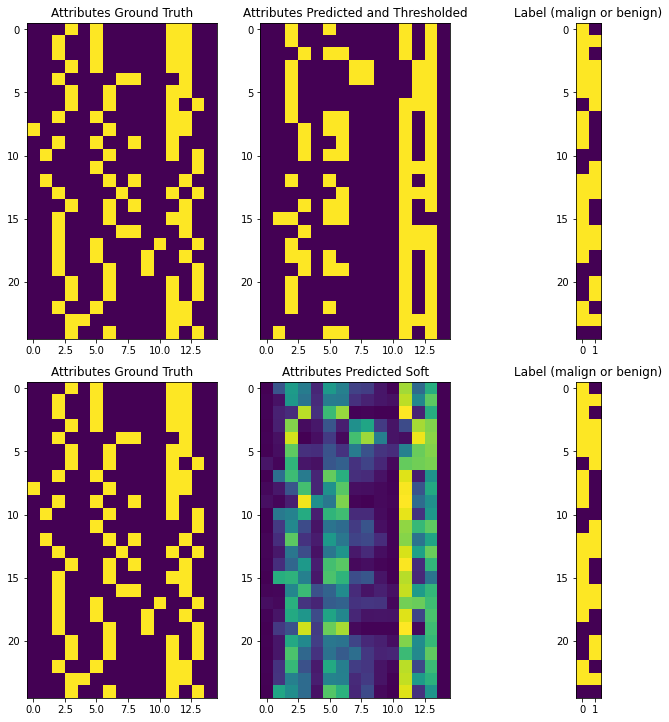

In [48]:
## ALL this should be on TEST set
# Visualizing the results for attributes and labels
attr_pred = np.squeeze(np.array(attr_pred))
attr_gt = np.squeeze(np.array(attr_gt))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(231)    # The big subplot
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


ax1.imshow(attr_gt)
ax1.set_title("Attributes Ground Truth")
ax2.imshow((attr_pred > 0.5) * 1)
ax2.set_title("Attributes Predicted and Thresholded")

ax3.imshow(viz)
ax3.set_title("Label (malign or benign)")

ax4.imshow(attr_gt)
ax4.set_title("Attributes Ground Truth")
ax5.imshow(attr_pred )
ax5.set_title("Attributes Predicted Soft")

ax6.imshow(viz)
ax6.set_title("Label (malign or benign)")


plt.tight_layout(pad=0.6, w_pad=0, h_pad=1.0)


Text(0.5, 0, 'Attribute probability')

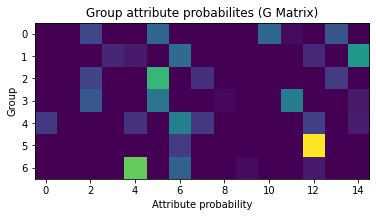

In [39]:
# Visualizing G matrix
plt.imshow(model.G_.data.detach().cpu().numpy())
plt.title("Group attribute probabilites (G Matrix)")
plt.ylabel("Group")
plt.xlabel("Attribute probability")

Text(0.5, 0, 'W values')

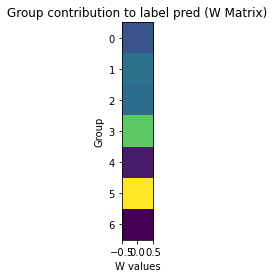

In [49]:
# Visualizing W Matrix
plt.imshow(model.W_.data.detach().cpu().numpy())
plt.title("Group contribution to label pred (W Matrix)")
plt.ylabel("Group")
plt.xlabel("W values")

In [93]:
# Legacy CAM code
# class CamExtractor():
#     """
#         Extracts cam features from the model
#     """
#     def __init__(self, model, target_layer):
#         self.model = model
#         self.target_layer = target_layer
        

#     def forward_pass_on_convolutions(self, x):
#         """
#             Does a forward pass on convolutions, hooks the function at given layer
#         """
#         conv_output = None
#         module_pos = 1
#         for module in self.model.features:
#             x = model.pool(module(x))  # Forward
#             if int(module_pos) == self.target_layer:
#                 conv_output = x  # Save the convolution output on that layer
#             module_pos += 1
#         return conv_output, x

#     def forward_pass(self, x):
#         """
#             Does a full forward pass on the model
#         """
#         conv_output, _ = self.forward_pass_on_convolutions(x)
#         x = F.interpolate(x, (300, 300), mode='bilinear')
#         (x_, _) = model(x)
#         return conv_output, x_

    
# extractor = CamExtractor(model, 4)

# count = 0
# for data in test_generator:
#     y_im_test = data["labels"][:, 15].to(device)
#     x_im_test = data["image"]
#     x_im_test = x_im_test.to(device)


#     [conv_out, x] = extractor.forward_pass_on_convolutions(x_im_test)
#     target = conv_out
#     cam = np.ones((target.shape[1:]), dtype=np.float32)
#     sal_map = np.zeros((224, 224))
#     for i in range(np.shape(target)[1]):
#                 # Unsqueeze to 4D
#                 saliency_map = torch.unsqueeze(torch.unsqueeze(target[0, i, :, :],0),0)
#                 # Upsampling to input size
#                 saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
#                 if saliency_map.max() == saliency_map.min():
#                     continue
#                 # Scale between 0-1
#                 norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
#                 inim = F.interpolate(x_im_test, size=(224, 224), mode='bilinear')
#                 w = extractor.forward_pass(inim * norm_saliency_map)[1]
#                 sal_map += w.cpu().data.numpy() * norm_saliency_map.cpu().data.numpy()[0, 0, :, :]
#                 cam += w.cpu().data.numpy() * target[0, i, :, :].cpu().data.numpy()


#     fig = plt.figure(figsize=(15, 10))

#     ax0 = fig.add_subplot(131)
#     ax0.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))

#     ax1 = fig.add_subplot(132)
#     ax1.imshow(sal_map)

#     ax2 = fig.add_subplot(133)
#     ax2.imshow(cam[0, :, :])
#     count += 1
#     if(count == 10):
#         break


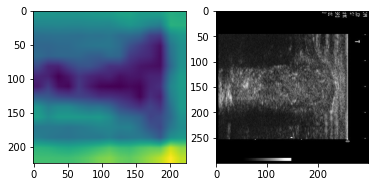

In [56]:
# Legacy CAM code
# fig = plt.figure()
# ax0 = fig.add_subplot(121)
# ax0.imshow(sal_map)

# ax1 = fig.add_subplot(122)
# ax1.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))



In [50]:
#Sankey plot code for G matrix
source = [i % a for i in range(z*a)]
target = [(i // 15) + 15 for i in range(z*a)]
G[G < 0.1] = 0.0
value = G.flatten().tolist()
#print(len(source), len(target), len(value))

color_node = [
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#808080', '#808080', '#808080', '#808080', '#808080',
              '#FF0000', '#FFFF00', '#00FF00', '#00FFFF', '#FF00FF',
              '#00CED1', '#FF8C00', '#BDB76B', '#2F4F4F', '#B8860B'
              ]

color_link = []
link_colors = ['#F08080', '#FFFACD', '#98FB98', '#87CEFA', '#EE82EE',
              '#AFEEEE', '#FFA500', '#F0E68C', '#708090', '#DAA520']

In [32]:
for i in range(z):
    color_link.extend([link_colors[i]] * a)
#print(color_link)
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      color = color_node,
      label = ["cystic", "mostly solid", "solid", "spongiform",
               "hyper", "hypo", "iso", "marked",
               "ill-defined", "micro", "spiculated", "smooth",
               "macro", "micro", "non",
               "G1", "G2", "G3", "G4", "G5",
               "G6", "G7", "G8", "G9", "G10"],
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color_link
  ))])
fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()